In [1]:
#Run the kSZ 4-point function
#
#
from os.path import join as opj, dirname
import os
os.environ["DISABLE_MPI"]="true"
from ksz4.cross import four_split_K, split_phi_to_cl
from ksz4.reconstruction import setup_recon, setup_ABCD_recon, get_cl_smooth
from pixell import curvedsky, enmap
from scipy.signal import savgol_filter
from cmbsky import safe_mkdir, get_disable_mpi, ClBinner
from falafel import utils, qe
import healpy as hp
import yaml
import argparse
from orphics import maps
import numpy as np
import matplotlib.pyplot as plt
import pickle
from plot_tools import *

/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/cmbsky-0.0.1-py3.8.egg/cmbsky/utils.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


In [7]:
log_binner=False
binner = ClBinner(lmin=5, lmax=300, nbin=8, log=log_binner)

In [8]:
## also add theory
outputs_dir='/pscratch/sd/m/maccrann/cmb/fg_outputs'
def get_fg_terms(tag, recon_tag, freq):
    fg_term_file = opj(outputs_dir, tag, 
                       "ksz2_fg_terms_%s/fg_terms_%s.npy"%(
                           recon_tag, freq)
                      )
    return np.load(fg_term_file)


In [9]:
#DEFAULT_CL_RKSZ=np.load("../tests/cl_4e3_2048_50_50_ksz.npy")
#UL = np.sqrt(DEFAULT_CL_RKSZ)

#### read auto output

In [10]:
mask_60sk_file = "/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_60.00sk.fits"
mask = enmap.read_map(mask_60sk_file)
w1 = maps.wfactor(1,mask)
w4 = maps.wfactor(4,mask)
w2 = maps.wfactor(2,mask)

## Baseline data plots

est: qe
alt_norm_AB: 6.427723338753566e-10
norm_K_AB: [0.00000000e+00 1.16913445e-08 1.16964659e-08 ... 5.80736481e-08
 5.78921381e-08 5.79791872e-08]
u_L: [0.00119956 0.00119956 0.00119956 ... 0.00083553 0.00083417 0.00083472]
only use altnorm when divide_by_uL is False


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:112: RuntimeWarning: divide by zero encountered in true_divide
  outputs["alt_norm_over_orig_norm"] = ((2*u_L)**2 * alt_norm_AB * alt_norm_CD /
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:141: RuntimeWarning: invalid value encountered in multiply
  prefactor *= Ls**lpower


nans in CL_KK_raw
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False Fa

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:58: RuntimeWarning: invalid value encountered in multiply
  fg_bias = fg_bias[:len(prefactor)]*prefactor


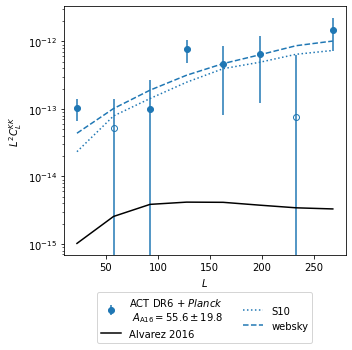

In [28]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(5,5))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=False
plot_meanfield_correction=False
lpower=2
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=False
use_alt_norm=False
use_r24_norm=True
plot_theory=True
plot_scaled_theory=False
transfer_func=0.94
check_auto=False

d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
clkk_stuff_4000 = plot_clKK(ax, d4000, 
           binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"ACT DR6 + $\it{Planck}$",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64, plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = 0., est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)

if (use_alt_norm or use_r24_norm):
    print(clkk_stuff_4000["alt_norm_over_orig_norm"])
    fg_prefactor=clkk_stuff_4000["alt_norm_over_orig_norm"]
else:
    fg_prefactor=None

#Get foreground contribution estimated from websky
fg_bias_websky_iiii_lmax4000,fg_prof = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                        divide_by_uL=divide_by_uL, lpower=lpower, 
                                                    prefactor=fg_prefactor)
assert np.allclose(fg_prof[:4000], clkk_stuff_4000["profile"][:4000])
ax.plot(binner.bin_mids, 
        binner(fg_bias_websky_iiii_lmax4000[:binner.lmax+1]), '--', color="C0")
ax.plot([],[],'--',color='C0', label="websky")

#fg_bias_websky_iiii_lmax5000 = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk",
#                                         "lmin3000_lmax5000",
#                                         "ilc_ilc_ilc_ilc", "qe", 
#                                                 divide_by_uL2=divide_by_uL2) 
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower * fg_bias_websky_iiii_lmax5000[:binner.lmax+1]), '--', color='C1')

fg_bias_sehgal_iiii_lmax4000,_ = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, lpower=lpower,
                                                   prefactor=fg_prefactor)
ax.plot([],[],':',color='C0', label="S10")
ax.plot(binner.bin_mids, 
        binner(fg_bias_sehgal_iiii_lmax4000[:binner.lmax+1]), ':', color='C0')
#fg_bias_sehgal_iiii_lmax5000 = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk",
#                                         "lmin3000_lmax5000",
#                                         "ilc_ilc_ilc_ilc", "qe",
#                                                 divide_by_uL2=divide_by_uL2) 
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower * fg_bias_sehgal_iiii_lmax5000[:binner.lmax+1]), ':', color='C1')



#fg_terms_iici=np.load(
#    "/pscratch/sd/m/maccrann/cmb/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk/ksz2_fg_terms_lmax4000/fg_terms_ilc_ilc_ilc_ilc.npy")
#print("profile:",fg_terms_iici["profile"])
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower *
#            fg_terms_iici["trispectrum_qe"][:binner.lmax+1]/fg_terms_iici["profile"][:binner.lmax+1]**2
#        ), '--', color='C1')


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=2, reverse=True)

#if binner.log:
#ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.28)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
#filename="CLKK_dr6_biases_hilc.png"

new_plot_dir="new_plots"
filename=opj(new_plot_dir, "CLKK_dr6_baseline_hilc_v4.png")
if use_alt_norm:
    filename=opj(new_plot_dir, "CLKK_dr6_baseline_hilc_v4_alt_norm.png")
elif use_r24_norm:
    filename=opj(new_plot_dir, "CLKK_dr6_baseline_hilc_v4_r24_norm.png")
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

In [13]:
50**2

2500

# ivar weighting 

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


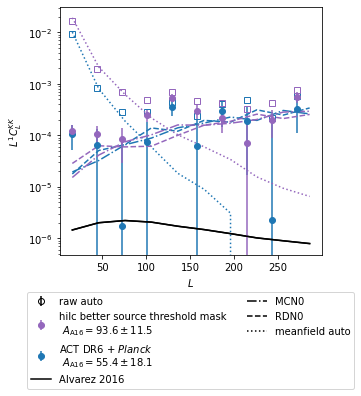

In [29]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(5,5))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=True
plot_meanfield_correction=False
lpower=1
plot_raw_auto=True
plot_mcn0=True
do_one_leg_cleaned=False
plot_meanfield=True
ylim=None #[-0.5,2]
divide_by_uL=True
use_alt_norm=False
use_r24_norm=False
plot_theory=True
plot_scaled_theory=False
transfer_func=0.94
check_auto=False


d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
clkk_stuff_4000 = plot_clKK(ax, d4000, 
           binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"ACT DR6 + $\it{Planck}$",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)

d4000_sourcethresh = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask"
#need to read in ivar map for w1 and w4
ivar_map = enmap.read_map("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask/weight_map.fits")
clkk_stuff_4000_ivarw = plot_clKK(ax,  d4000_sourcethresh, 
           binner, mask=opj(d4000_sourcethresh,"weight_map.fits"), color='C4', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"hilc better source threshold mask",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=2, reverse=True)

#if binner.log:
#ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.28)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
filename="CLKK_dr6_hilc_ivarw.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

In [30]:
# day-dnight coadd ivar weighting

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:185: RuntimeWarning: invalid value encountered in true_divide
  print(np.abs(CL_KK_raw_from_Ks[binner.lmin:binner.lmax] / outputs["CL_KK_raw"][binner.lmin:binner.lmax]-1) > 1.e-2)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  T

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


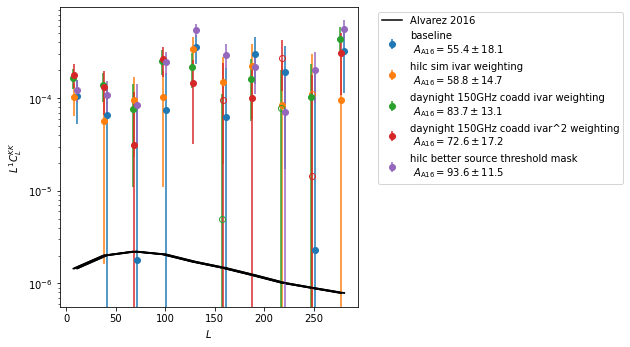

In [6]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(9,6))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-5,5,6)
plot_rdn0=False
plot_meanfield_correction=False
lpower=1
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
use_alt_norm=False
use_r24_norm=False
plot_theory=True
plot_scaled_theory=False
transfer_func=0.94
check_auto=False



#need to read in ivar map for w1 and w4
#ivar_map = enmap.read_map("/global/cfs/projectdirs/act/data/maccrann/dr6/map_coadd_20240322_act_s17_s22_f150_daynight_ivar.fits")[0]
#ivar_map = enmap.smooth_gauss(ivar_map, np.radians(1.))
d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
clkk_stuff_4000 = plot_clKK(ax, d4000, 
           binner, mask=mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"baseline",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)



d4000_ivarw = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_ivarw"
#need to read in ivar map for w1 and w4
ivar_map = enmap.read_map("/global/homes/m/maccrann/cmb/ksz2/sims/ivar_map_nsim200/ivar_map.fits")
ivar_map *= mask
clkk_stuff_4000_ivarw = plot_clKK(ax,  d4000_ivarw, 
           binner, mask=ivar_map, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"hilc sim ivar weighting",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = offsets[1], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_ivarw_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_ivarw_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)

d4000_dnivarw = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_dnivarw-smooth"
clkk_stuff_4000_dnivarw = plot_clKK(ax,  d4000_dnivarw, 
           binner, mask=opj(d4000_dnivarw,"weight_map.fits"), color='C2', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"daynight 150GHz coadd ivar weighting",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = offsets[2], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_dnivarw-smooth_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_dnivarw-smooth_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)

d4000_dnivarw2 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_dnivarw-smooth2"
#need to read in ivar map for w1 and w4
#ivar_map = enmap.read_map("/global/cfs/projectdirs/act/data/maccrann/dr6/map_coadd_20240322_act_s17_s22_f150_daynight_ivar.fits")[0]
#ivar_map = enmap.smooth_gauss(ivar_map, np.radians(1.))
#w_map = (ivar_map*mask)**2
clkk_stuff_4000_ivarw2 = plot_clKK(ax,  d4000_dnivarw2, 
           binner, mask=opj(d4000_dnivarw2,"weight_map.fits"), color='C3', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"daynight 150GHz coadd ivar^2 weighting",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = offsets[3], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_dnivarw-smooth2_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_dnivarw-smooth2_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)




d4000_sourcethresh = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask"
#need to read in ivar map for w1 and w4
ivar_map = enmap.read_map("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask/weight_map.fits")
clkk_stuff_4000_ivarw = plot_clKK(ax,  d4000_sourcethresh, 
           binner, mask=opj(d4000_sourcethresh,"weight_map.fits"), color='C4', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"hilc better source threshold mask",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           add_offset = offsets[4], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=1, reverse=False)

#if binner.log:
#ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.28)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
filename="CLKK_dr6_hilc_dnivarw.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

In [10]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(9,5))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=False
plot_meanfield_correction=False
lpower=1
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
use_alt_norm=False
use_r24_norm=False
plot_theory=True
plot_scaled_theory=False
transfer_func=0.94
check_auto=False



#need to read in ivar map for w1 and w4
#ivar_map = enmap.read_map("/global/cfs/projectdirs/act/data/maccrann/dr6/map_coadd_20240322_act_s17_s22_f150_daynight_ivar.fits")[0]
#ivar_map = enmap.smooth_gauss(ivar_map, np.radians(1.))


d4000_dnivarw = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_dnivarw-smooth"
clkk_stuff_4000_dnivarw = plot_clKK(ax,  d4000_dnivarw, 
           binner, mask=None, color='C2', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"one-leg tSZ deprojected,"+"\n"+"daynight 150GHz coadd ivar weighting",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_dnivarw-smooth_hilc_hilc-tszd_hilc_hilc/output_auto_config_lmax4000_dnivarw-smooth_hilc_hilc-tszd_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)


d4000_dnivarw2 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_dnivarw-smooth2"
clkk_stuff_4000_ivarw2 = plot_clKK(ax,  d4000_dnivarw2, 
           binner, mask=None, color='C3', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"one-leg tSZ deprojected,"+"\n"+"daynight 150GHz coadd ivar^2 weighting",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_dnivarw-smooth2_hilc_hilc-tszd_hilc_hilc/output_auto_config_lmax4000_dnivarw-smooth2_hilc_hilc-tszd_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)


d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
clkk_stuff_4000 = plot_clKK(ax, d4000, 
           binner, mask=mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"one-leg tSZ deprojected, no weighing",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc-tszd_hilc_hilc/output_auto_config_lmax4000_hilc_hilc-tszd_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)




if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.), ncol=1, reverse=True)

#if binner.log:
#ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.28)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
filename="CLKK_dr6_hilc_dnivarw_tszd.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1959240/239007039.py", line 50, in <module>
    clkk_stuff_4000_ivarw2 = plot_clKK(ax,  d4000_dnivarw2,
  File "/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py", line 378, in plot_clKK
    cl_kk_stuff = get_CLKK_stuff(outputs_dir, rdn0_file, binner, w1=w1, w4=w4, nsim_meanfield=nsim_meanfield,
  File "/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py", line 183, in get_CLKK_stuff
    CL_KK_raw_from_Ks = prefactor * split_phi_to_cl(Ks_ab_raw, Ks_cd_raw)/w4
  File "/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/ksz4-0.0.1-py3.8.egg/ksz4/cross.py", line 256, in split_phi_to_cl
    tg3=m*(cs.alm2cl(phi01,phi01p)+cs.alm2cl(phi02,phi02p)+cs.alm2cl(phi03,phi03p)+cs.alm2cl(phi12,phi12p)+cs.alm2cl(phi13,phi13p)+cs.al

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x7f8eabaf0550> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# source threshold mask

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:329: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


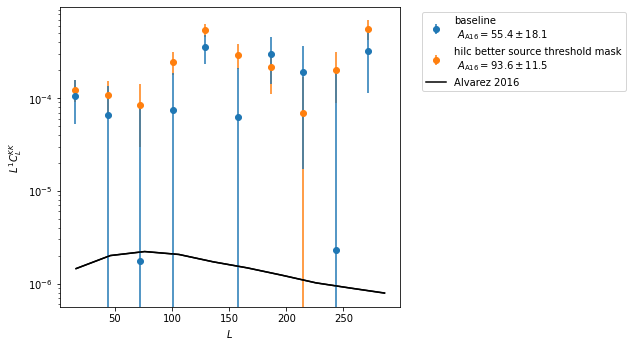

In [14]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(9,6))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=False
plot_meanfield_correction=False
lpower=1
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
use_alt_norm=False
use_r24_norm=False
plot_theory=True
plot_scaled_theory=False
transfer_func=0.94
check_auto=False



#need to read in ivar map for w1 and w4
#ivar_map = enmap.read_map("/global/cfs/projectdirs/act/data/maccrann/dr6/map_coadd_20240322_act_s17_s22_f150_daynight_ivar.fits")[0]
#ivar_map = enmap.smooth_gauss(ivar_map, np.radians(1.))


d4000_ivarw = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask"
#need to read in ivar map for w1 and w4
ivar_map = enmap.read_map("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_sourcethreshmask/weight_map.fits")
clkk_stuff_4000_ivarw = plot_clKK(ax,  d4000_ivarw, 
           binner, mask=ivar_map, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"hilc better source threshold mask",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)


d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
clkk_stuff_4000 = plot_clKK(ax, d4000, 
           binner, mask=mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label=r"baseline",  
           yscale=yscale,  lpower=lpower,
           nsim_meanfield=64,  plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         plot_scaled_theory=plot_scaled_theory,
         transfer_func=0.94, use_alt_norm=use_alt_norm, use_r24_norm=use_r24_norm)




if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=1, reverse=True)

#if binner.log:
#ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.28)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
filename="CLKK_dr6_hilc_sourcethreshmask.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

In [8]:
clkks_baseline=np.load("/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")
clkks_ivarw=np.load("/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_ivarw_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_ivarw_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")
clkks_dnivarw=np.load("/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_dnivarw_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_dnivarw_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")
clkks_sourcethreshmask=np.load("/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_sourcethreshmask_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")

In [9]:
clkks_binned_baseline = np.zeros((clkks_baseline.shape[0], binner.nbin))
clkks_binned_ivarw = np.zeros((clkks_ivarw.shape[0], binner.nbin))
clkks_binned_dnivarw = np.zeros_like(clkks_binned_ivarw)
clkks_binned_sourcethreshmask = np.zeros_like(clkks_binned_ivarw)
for i,c in enumerate(clkks_baseline):
    clkks_binned_baseline[i] = binner(c)
    clkks_binned_ivarw[i] = binner(clkks_ivarw[i])
    clkks_binned_dnivarw[i] = binner(clkks_dnivarw[i])
    clkks_binned_sourcethreshmask[i] = binner(clkks_sourcethreshmask[i])
    
clkk_binned_cov_baseline = np.cov(clkks_binned_baseline.T)
clkk_binned_cov_ivarw = np.cov(clkks_binned_ivarw.T)
clkk_binned_cov_dnivarw = np.cov(clkks_binned_dnivarw.T)
clkk_binned_cov_sourcethreshmask = np.cov(clkks_binned_sourcethreshmask.T)
                                              

In [10]:
print(clkk_binned_cov_ivarw.shape)

(10, 10)


Text(0, 0.5, '$\\sigma(C_L^{KK})$')

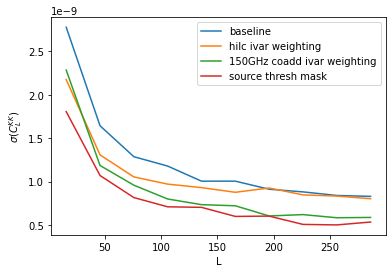

In [14]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(binner.bin_mids, np.sqrt(np.diag(clkk_binned_cov_baseline)), label="baseline")
ax.plot(binner.bin_mids, np.sqrt(np.diag(clkk_binned_cov_ivarw)), label="hilc ivar weighting")
ax.plot(binner.bin_mids, np.sqrt(np.diag(clkk_binned_cov_dnivarw)), label="150GHz coadd ivar weighting")
ax.plot(binner.bin_mids, np.sqrt(np.diag(clkk_binned_cov_sourcethreshmask)), label="source thresh mask")

ax.legend()

ax.set_xlabel(r"L")
ax.set_ylabel(r"$\sigma(C_L^{KK})$")

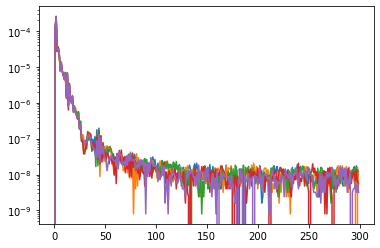

In [21]:
%matplotlib inline

fig,ax=plt.subplots()

for i in range(5):
    with open("/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_ivarw_hilc_hilc_hilc_hilc/output_rot%s/auto_outputs.pkl"%i, "rb") as f:
        auto_outputs=pickle.load(f)
    ax.plot(auto_outputs["cl_KK_raw"][:300])
ax.set_yscale('log')

## lmax

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


lpower: 2
lpower: 2


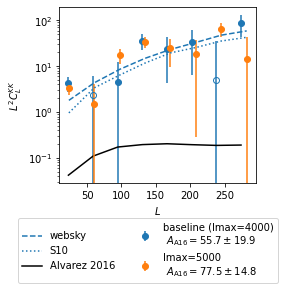

In [13]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(4,4))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=1+np.linspace(-0.03,0.03,2)
plot_rdn0=False
plot_meanfield_correction=False
lpower=2
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
plot_theory=True
transfer_func=0.94
check_auto=False

d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims"
plot_clKK(ax, d4000, 
           binner, mask_60sk_file, color='C0', rdn0_file=opj(d4000,"rdn0_outputs_nsim64.pkl"),
           label="baseline (lmax=4000)",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir=opj(d4000,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           mult_offset = offsets[0], est="qe", divide_by_uL=divide_by_uL,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,check_auto=check_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)
d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_noisysims"
plot_clKK(ax, d5000, 
           binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
           label="lmax=5000",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           mult_offset = offsets[1], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=False,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc_hilc_hilc/output_auto_config_lmax5000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)

#d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/"
    #plot_clKK(ax, d5000, 
    #                   binner, mask_60sk_file, color='C1', rdn0_file=opj(d5000,"rdn0_outputs_nsim64.pkl"),
    #          label="lmax=5000",  est="qe",
    #           yscale=yscale,  lpower=lpower,
    #          meanfield_dir=opj(d5000,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
    #          offsets = offsets[1], divide_by_uL2=divide_by_uL2,
    #         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
    #         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
    #        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
    #         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc_hilc_hilc/output_auto_config_lmax5000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")

    #d6000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax6000_mask60sk_gausssims/"
    #plot_clKK(ax, d6000, 
    #                   binner, mask_60sk_file, color='C2', rdn0_file=opj(d6000,"rdn0_outputs_nsim64.pkl"),
    #          label="hILC, lmax=6000",  est="qe",
    #           yscale=yscale,  lpower=lpower,
    #          meanfield_dir=opj(d6000,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
    #          offsets = offsets[1], divide_by_uL2=divide_by_uL2,
    #         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
    #         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
    #        plot_meanfield_correction=plot_meanfield_correction,
    #        sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_hilc_hilc_hilc_hilc/output_auto_config_lmax6000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy") 
    
    #dlowl = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v7000_lmin2000_lmax3000_mask60sk_gausssims/"
    #plot_clKK(ax, dlowl, 
    #                   binner, mask_60sk_file, color='C2', rdn0_file=opj(dlowl,"rdn0_outputs_nsim32.pkl"),
    #          label="hILC, lmin=2000, lmax=5000",  
    #           yscale=yscale,  lpower=lpower,
    #          meanfield_dir=opj(dlowl,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
    #          offsets = offsets[1], divide_by_uL2=divide_by_uL2,
    #         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
    #         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
    #        plot_meanfield_correction=plot_meanfield_correction) #, u_L=u_L)





#Get foreground contribution estimated from websky
fg_bias_websky_iiii_lmax4000,_ = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                        divide_by_uL=divide_by_uL, lpower=lpower) 
ax.plot(binner.bin_mids, 
        binner(fg_bias_websky_iiii_lmax4000[:binner.lmax+1]), '--', color="C0")
ax.plot([],[],'--',color='C0', label="websky")

#fg_bias_websky_iiii_lmax5000 = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk",
#                                         "lmin3000_lmax5000",
#                                         "ilc_ilc_ilc_ilc", "qe", 
#                                                 divide_by_uL2=divide_by_uL2) 
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower * fg_bias_websky_iiii_lmax5000[:binner.lmax+1]), '--', color='C1')

fg_bias_sehgal_iiii_lmax4000,_ = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, lpower=lpower) 
ax.plot([],[],':',color='C0', label="S10")
ax.plot(binner.bin_mids, 
        binner(fg_bias_sehgal_iiii_lmax4000[:binner.lmax+1]), ':', color='C0')
#fg_bias_sehgal_iiii_lmax5000 = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk",
#                                         "lmin3000_lmax5000",
#                                         "ilc_ilc_ilc_ilc", "qe",
#                                                 divide_by_uL2=divide_by_uL2) 
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower * fg_bias_sehgal_iiii_lmax5000[:binner.lmax+1]), ':', color='C1')



#fg_terms_iici=np.load(
#    "/pscratch/sd/m/maccrann/cmb/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk/ksz2_fg_terms_lmax4000/fg_terms_ilc_ilc_ilc_ilc.npy")
#print("profile:",fg_terms_iici["profile"])
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower *
#            fg_terms_iici["trispectrum_qe"][:binner.lmax+1]/fg_terms_iici["profile"][:binner.lmax+1]**2
#        ), '--', color='C1')


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.17), ncol=2)


if log_binner:
    ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.35, right=0.9)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
#filename="CLKK_dr6_biases_hilc.png"

new_plot_dir="new_plots"
filename=opj(new_plot_dir, "CLKK_dr6_baseline_lmaxtest.png")
if use_alt_norm:
    filename=opj(new_plot_dir, "CLKK_dr6_baseline_lmaxtest_alt_norm.png")
elif use_r24_norm:
    filename=opj(new_plot_dir, "CLKK_dr6_baseline_lmaxtest_r24_norm.png")
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

filename="CLKK_dr6_baseline_lmaxtest.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

## Bias hardening

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:308: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:310: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: lh
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:308: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:310: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


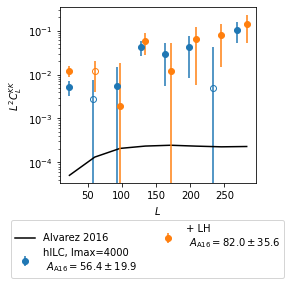

In [16]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(4,4))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,3)
plot_rdn0=False
plot_meanfield_correction=False
lpower=2
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
check_auto=False


d_qe = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims/"
plot_clKK(ax, d_qe, 
           binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
           label="hILC, lmax=4000",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir=opj(d_qe,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction,
             sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)
   
d_lh = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_lh/"
plot_clKK(ax, d_lh, 
           binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_lh_nsim64.pkl",
           label="+ LH",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir=opj(d_lh,"mean_field_nsim64_lh"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[1], est="lh", divide_by_uL=divide_by_uL, check_auto=check_auto,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), , check_auto=check_auto,
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction, plot_theory=False,
         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_lh_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_lh_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)

#d_psh = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_psh/"
#plot_clKK(ax, d_psh, 
#           binner, mask_60sk_file, color='C2', rdn0_file="rdn0_outputs_psh_nsim64.pkl",
#           label="+ PSH",  
#           yscale=yscale,  lpower=lpower,
#           meanfield_dir=opj(d_psh,"mean_field_nsim64_psh"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#           offsets = offsets[2], est="psh", divide_by_uL=divide_by_uL,
#           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#           plot_meanfield_correction=plot_meanfield_correction,
#         sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_psh_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_psh_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
if plot_theory:
    ax.plot([],[],"-",color="k", label="Alvarez 2016")
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)


if log_binner:
    ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.35, right=0.9)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
#filename="CLKK_dr6_biases_hilc.png"

filename="CLKK_dr6_bh_hilc_v4.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

## One leg cleaned

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


lpower: 0
lpower: 0
lpower: 0
lpower: 0
[ 0.         -0.15843672 -0.03000512 ... -0.00031608 -0.0003357
 -0.00035767]


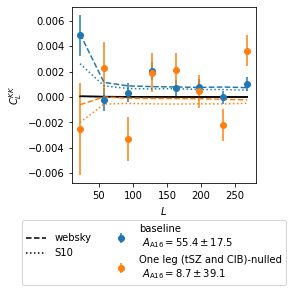

In [14]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(4,4))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="linear"
linthreshy=1.e-3
offsets=1+np.linspace(-0.05,0.05,3)
plot_rdn0=False
plot_meanfield_correction=False
lpower=0
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
plot_theory=True
check_auto=False


d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims/"
plot_clKK(ax, d4000, 
                   binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="baseline",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          mult_offset = offsets[0], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory, check_auto=check_auto,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)

#d4000_actonly = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_actonly_gausssims/"
#plot_clKK(ax, d4000_actonly, 
#                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
#          label="ACT only",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = offsets[0], divide_by_uL=divide_by_uL,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
#          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")


d4000_onelegcleaned = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims/"
plot_clKK(ax, d4000_onelegcleaned, 
                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="One leg (tSZ and CIB)-nulled",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          mult_offset = offsets[1], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory, check_auto=check_auto,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc-tszandcibd_hilc_hilc/output_auto_config_lmax4000_hilc_hilc-tszandcibd_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94) #, u_L=u_L)

#d4000_tszd_psh="/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc-tszd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_psh"
#plot_clKK(ax, d4000_tszd_psh, 
#                   binner, mask_60sk_file, color='C2', rdn0_file="rdn0_outputs_psh_nsim64.pkl",
#          label="One leg tSZ-nulled + PSH",  
#           yscale=yscale,  lpower=lpower, est="psh",
#          meanfield_dir="mean_field_nsim64_psh", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = offsets[2], divide_by_uL=divide_by_uL,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
#          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_psh_hilc_hilc-tszd_hilc_hilc/output_auto_config_lmax4000_psh_hilc_hilc-tszd_hilc_hilc_CLKKs_nsim128.npy") 
#

fg_bias_websky_iiii_lmax5000,_ = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, 
                                                 lpower=lpower) 
ax.plot(binner.bin_mids, 
        binner(fg_bias_websky_iiii_lmax5000[:binner.lmax+1]), '--', color='C0')

fg_bias_websky_icii_lmax5000,_ = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_deproj-tsz-cib_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, 
                                                 lpower=lpower) 
ax.plot(binner.bin_mids, 
        binner(fg_bias_websky_icii_lmax5000[:binner.lmax+1]), '--', color='C1')

#fg_bias_websky_itii_psh_lmax5000 = get_fg_trispectrum("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl",
#                                         "lmin3000_lmax4000",
#                                         "ilc_deproj-tsz_ilc_ilc", "psh",
#                                                 divide_by_uL=divide_by_uL, 
#                                                 lpower=lpower) 
#ax.plot(binner.bin_mids, 
#        binner(fg_bias_websky_itii_psh_lmax5000[:binner.lmax+1]), '--', color='C2')


ax.plot([],[],'--',color='k', label="websky")

fg_bias_sehgal_iiii_lmax5000,_ = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_ilc_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, 
                                                 lpower=lpower) 

ax.plot([],[],':',color='k', label="S10")
ax.plot(binner.bin_mids, 
        binner(fg_bias_sehgal_iiii_lmax5000[:binner.lmax+1]), ':', color='C0')
fg_bias_sehgal_icii_lmax5000,_ = get_fg_trispectrum("sehgal_allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2-no545_mask60sk_dataCl",
                                         "lmin3000_lmax4000",
                                         "ilc_deproj-tsz-cib_ilc_ilc", "qe",
                                                 divide_by_uL=divide_by_uL, 
                                                 lpower=lpower) 
print(fg_bias_sehgal_icii_lmax5000)
ax.plot(binner.bin_mids, 
        binner(fg_bias_sehgal_icii_lmax5000[:binner.lmax+1]), ':', color='C1')



#fg_terms_iici=np.load(
#    "/pscratch/sd/m/maccrann/cmb/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk/ksz2_fg_terms_lmax4000/fg_terms_ilc_ilc_ilc_ilc.npy")
#print("profile:",fg_terms_iici["profile"])
#ax.plot(binner.bin_mids, 
#        binner(np.arange(binner.lmax+1)**lpower *
#            fg_terms_iici["trispectrum_qe"][:binner.lmax+1]/fg_terms_iici["profile"][:binner.lmax+1]**2
#        ), '--', color='C1')


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.18), ncol=2)

ax.ticklabel_format(style='sci', axis='y')

if log_binner:
    ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()
plt.subplots_adjust(bottom=0.35, right=0.9)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
#filename="CLKK_dr6_biases_hilc.png"

filename="CLKK_dr6_onelegcleaned_v4.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

## something weird going on with the tszd PSH version


In [ ]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(5,5))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=True
yscale="log"
linthreshy=1.
offsets=np.linspace(-0.05,0.05,3)
plot_rdn0=True
plot_meanfield_correction=True
lpower=2
plot_raw_auto=True
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=True
ylim=None #[-0.5,2]
divide_by_uL=True


d4000_tszd_psh="/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc-tszd_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims_psh"
plot_clKK(ax, d4000_tszd_psh, 
                   binner, mask_60sk_file, color='C2', rdn0_file="rdn0_outputs_psh_nsim64.pkl",
          label="One leg tSZ-nulled + PSH",  
           yscale=yscale,  lpower=lpower, est="psh",
          meanfield_dir="mean_field_nsim64_psh", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[2], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_psh_hilc_hilc-tszd_hilc_hilc/output_auto_config_lmax4000_psh_hilc_hilc-tszd_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94) 

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)



ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    

## Plot with biases

In [ ]:
%matplotlib inline

yscale="log"
linthreshy=1.e-8
plot_rdn0=True
plot_meanfield_correction=True
lpower=2
plot_raw_auto=True
plot_mcn0=True
plot_meanfield=True
offsets=np.linspace(-0.03,0.03,3)
ylim=None #[-0.5,2]
divide_by_uL2=False
plot_theory=True
offsets=None

fig,ax=plt.subplots(figsize=(5,5))

#d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/"
d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_noisy sims/"
plot_clKK(ax, d5000, 
                   binner, mask_60sk_file, color='k', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="hILC, lmax=5000",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[1], divide_by_uL2=divide_by_uL2,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc_hilc_hilc/output_auto_config_lmax5000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")

#d5000_old = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v7000_lmax5000_mask60sk_gausssims"
#plot_clKK(ax, d5000_old, 
#                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim32.pkl",
#          label="hILC, one leg cleaned, lmax=5000",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = None, divide_by_uL2=divide_by_uL2,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory) #, u_L=u_L)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")

if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)



ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()


filename="CLKK_dr6_biases_v4.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

## No cross version

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


meanfield correction: [ 57.33832595  17.24356515   7.89100849  -3.27086697  -3.50726941
 -11.3637074   -3.47354405 -21.09473174]
est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:325: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:327: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


meanfield correction: [ 52.81726113  15.89152188   5.79337681  -4.08633303  -5.29792042
 -15.59981703  -2.17916539 -20.75213828]


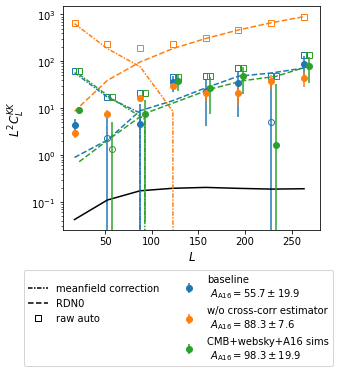

In [16]:
%matplotlib inline

yscale="log"
linthreshy=1.e-8
plot_rdn0=True
plot_meanfield_correction=True
plot_meanfield=False
lpower=2
plot_raw_auto=True
plot_mcn0=False
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL=True
plot_theory=True
offsets=np.linspace(-5.,5.,3)
check_auto=False

fig,ax=plt.subplots(figsize=(5,5))

d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims/"
plot_clKK(ax, d4000, 
                   binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="baseline",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          add_offset = offsets[0], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto, check_auto=check_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)


#d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/"
d4000_nocross = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_nocross_gausssims/"
plot_clKK(ax, d4000_nocross, 
                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="w/o cross-corr estimator",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          add_offset = offsets[1], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,check_auto=check_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=False,
          no_cross=True,
         transfer_func=0.94)

d400_theorysims = "/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_webskyfganda16sims/"
plot_clKK(ax, d400_theorysims, 
                   binner, mask_60sk_file, color='C2', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="CMB+websky+A16 sims",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          add_offset = offsets[2], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=False,check_auto=check_auto,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)




#d5000_old = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v7000_lmax5000_mask60sk_gausssims"
#plot_clKK(ax, d5000_old, 
#                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim32.pkl",
#          label="hILC, one leg cleaned, lmax=5000",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = None, divide_by_uL2=divide_by_uL2,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory) #, u_L=u_L)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")

if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.plot([],[],'s',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.16), ncol=2)

if log_binner:
    ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$", fontsize=12)
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower, fontsize=12)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    

    
fig.tight_layout()

plt.subplots_adjust(bottom=0.35, right=0.9)

new_plot_dir="new_plots"

filename=opj(new_plot_dir, "CLKK_dr6_biases_v4_nocross.png")
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))


## RDN0 comparison

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:308: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:310: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:308: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:310: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:308: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:310: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


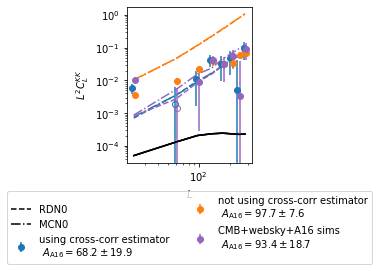

In [20]:
%matplotlib inline

yscale="log"
linthreshy=1.e-8
plot_rdn0=True
plot_meanfield_correction=False
lpower=2
plot_raw_auto=False
plot_mcn0=True
plot_meanfield=False
ylim=None #[-0.5,2]
divide_by_uL2=False
plot_theory=True
check_auto=False
offsets=np.linspace(-0.03,0.03,2)
plot_auto=False

fig,ax=plt.subplots(figsize=(4,4))

d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_gausssims/"
plot_clKK(ax, d4000, 
                   binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="using cross-corr estimator",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[0], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=False, check_auto=check_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy",
         transfer_func=0.94)


#d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/"
d4000_nocross = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_nocross_gausssims/"
plot_clKK(ax, d4000_nocross, 
                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="not using cross-corr estimator",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[1], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto, check_auto=check_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          no_cross=True,
         transfer_func=0.94)

#d4000_fullsims = "/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_fullsims/"
#plot_clKK(ax, d4000_fullsims, 
#                   binner, mask_60sk_file, color='C2', rdn0_file="rdn0_outputs_nsim64.pkl",
#          label="DR6 sims",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = offsets[1], divide_by_uL=divide_by_uL,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
#          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")
#
#
#d4000_webskysims = "/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_webskyfgsims/"
#plot_clKK(ax, d4000_webskysims, 
#                   binner, mask_60sk_file, color='C3', rdn0_file="rdn0_outputs_nsim64.pkl",
#          label="CMB+websky+A16 sims for bias correction",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = offsets[1], divide_by_uL=divide_by_uL,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
#          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")

d4000_webskyandkszsims = "/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_webskyfganda16sims/"
plot_clKK(ax, d4000_webskyandkszsims, 
                   binner, mask_60sk_file, color='C4', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="CMB+websky+A16 sims",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[1], divide_by_uL=divide_by_uL,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto, check_auto=check_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory,
          sim_CLKKs_file="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax4000_hilc_hilc_hilc_hilc/output_auto_config_lmax4000_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy")


#d5000_old = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v4_v7000_lmax5000_mask60sk_gausssims"
#plot_clKK(ax, d5000_old, 
#                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim32.pkl",
#          label="hILC, one leg cleaned, lmax=5000",  
#           yscale=yscale,  lpower=lpower,
#          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#          offsets = None, divide_by_uL2=divide_by_uL2,
#         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory) #, u_L=u_L)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")

if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.plot([],[],'s',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)



ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()

new_plot_dir="new_plots"

filename=opj(new_plot_dir,"CLKK_dr6_biases_v4_N0.png")
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

est: qe
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

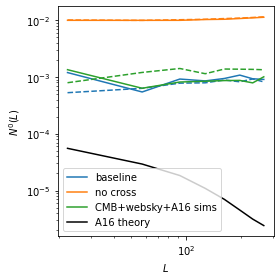

In [27]:
%matplotlib inline

check_auto=False

fig,ax=plt.subplots(figsize=(4,4))
#d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_gausssims/"
d4000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_noisysims/"
d4000_nocross = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_nocross_gausssims/"
d4000_theorysims = "/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_webskyfganda16sims/"

cl_kk_stuff_d4000 = get_CLKK_stuff(d4000, 
                             "rdn0_outputs_nsim64.pkl", binner, w1=w1, w4=w4, use_mcn0=False,
                            est="qe", divide_by_uL=True, sim_CLKKs=None, meanfield_dir = "mean_field_nsim64",
         transfer_func=0.94, check_auto=check_auto, nsim_meanfield=64)
d4000_nocross = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax4000_mask60sk_nocross_gausssims/"
cl_kk_stuff_d4000_nocross = get_CLKK_stuff(d4000_nocross,
                               "rdn0_outputs_nsim64.pkl", binner, w1=w1, w4=w4, use_mcn0=False,
                            est="qe", divide_by_uL=True, sim_CLKKs=None, no_cross=True,  
                                           meanfield_dir = "mean_field_nsim64",
         transfer_func=0.94, check_auto=check_auto, nsim_meanfield=64)         
#cl_kk_stuff_d4000_cmbsims = get_CLKK_stuff(d4000_cmbsims,
#                             "mean_field_nsim64", "rdn0_outputs_nsim64.pkl", w1, w4, binner, use_mcn0=False,
#                            est="qe", divide_by_uL=True, sim_CLKKs=None)     
#cl_kk_stuff_d4000_webskysims = get_CLKK_stuff(d4000_webskysims,
#                             "mean_field_nsim64", "rdn0_outputs_nsim64.pkl", w1, w4, binner, use_mcn0=False,
#                            est="qe", divide_by_uL2=False, sim_CLKKs=None) 
cl_kk_stuff_d4000_webskyandkszsims = get_CLKK_stuff(d4000_theorysims,
                              "rdn0_outputs_nsim64.pkl", binner, w1=w1, w4=w4, use_mcn0=False,
                            est="qe", divide_by_uL=True, sim_CLKKs=None, meanfield_dir = "mean_field_nsim64",
         transfer_func=0.94, check_auto=check_auto, nsim_meanfield=64) 

ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000["rdn0"]), "-", color="C0", label="baseline")
ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000["mcn0"]), "--", color="C0")
ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_nocross["rdn0"]), "-", color="C1", label="no cross")
ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_nocross["mcn0"]), "--", color="C1")
#ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_cmbsims["rdn0"]), "-", color="C2", label="cmb-only sims")
#ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_cmbsims["mcn0"]), "--", color="C2")
#ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_webskysims["rdn0"]), "-", color="C3", label="+websky sims")
#ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_webskysims["mcn0"]), "--", color="C3")
ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_webskyandkszsims["rdn0"]), "-", color="C2", label="CMB+websky+A16 sims")
ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000_webskyandkszsims["mcn0"]), "--", color="C2")

ax.plot(binner.bin_mids, binner(cl_kk_stuff_d4000["CL_KK_ksz_theory"]), color="k", label="A16 theory")

ax.legend()

ax.set_xscale('log')
ax.set_ylabel(r"$N^0(L)$")
ax.set_xlabel(r"$L$")
ax.set_yscale("log")

fig.tight_layout()
new_plot_dir="new_plots"

filename=opj(new_plot_dir,"N0_demo.png")
fig.savefig(filename, dpi=300)

## Check end-to-end sim

est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


meanfield correction: [8.72266918e-05 1.43844091e-05 3.51727115e-06 5.75847989e-07
 1.13952017e-07 1.57174413e-08 1.34582175e-09 3.55697316e-11]


/tmp/ipykernel_1736051/1178189182.py:47: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale(yscale, linthreshy=linthreshy)


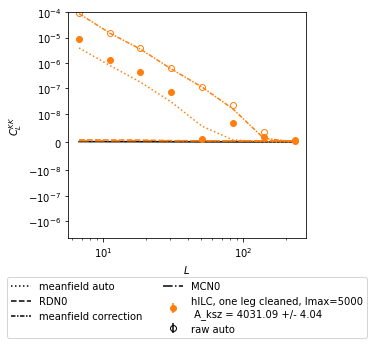

In [7]:
%matplotlib inline

yscale="symlog"
linthreshy=1.e-8
plot_rdn0=True
plot_meanfield_correction=True
lpower=0
plot_raw_auto=True
plot_mcn0=True
plot_meanfield=True
ylim=None #[-0.5,2]
divide_by_uL2=False
plot_theory=True

fig,ax=plt.subplots(figsize=(5,5))

d5000_onelegcleaned_e2e = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/"
plot_clKK(ax, d5000_onelegcleaned_e2e, 
                   binner, mask_60sk_file, color='C1', rdn0_file="rdn0_outputs_nsim32.pkl",
          label="hILC, one leg cleaned, lmax=5000",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = None, divide_by_uL2=divide_by_uL2,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto, est="qe",
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory) #, u_L=u_L)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)



ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()

## Baseline with biases

est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/rdn0_outputs_nsim64.pkl
64


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


meanfield correction: [ 8.55951263e-06  1.72751615e-06  3.92632280e-07  6.59836384e-08
  1.21022043e-08  1.88783739e-09  9.31595147e-11 -2.25676980e-12]


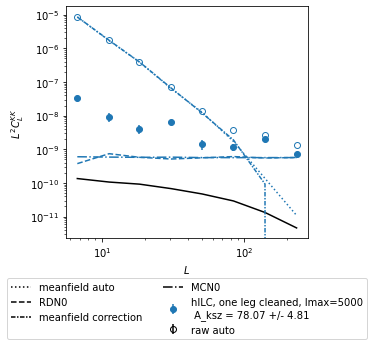

In [9]:
%matplotlib inline

linthreshy=1.e-8
plot_rdn0=True
plot_meanfield_correction=True
lpower=2
plot_raw_auto=True
plot_mcn0=True
plot_meanfield=True
ylim=None #[-0.5,2]
divide_by_uL2=False
plot_theory=True
yscale="log"

fig,ax=plt.subplots(figsize=(5,5))

d5000 = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/"
plot_clKK(ax, d5000, 
                   binner, mask_60sk_file, color='C0', rdn0_file="rdn0_outputs_nsim64.pkl",
          label="hILC, one leg cleaned, lmax=5000",  
           yscale=yscale,  lpower=lpower,
          meanfield_dir="mean_field_nsim64", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = None, divide_by_uL2=divide_by_uL2,
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
        plot_meanfield_correction=plot_meanfield_correction, plot_theory=plot_theory) #, u_L=u_L)

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)



ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
if lpower!=0:
    ax.set_ylabel(r"$L^{%d}C_L^{KK}$"%lpower)
else:
    ax.set_ylabel(r"$C_L^{KK}$")
    
if ylim is not None:
    ax.set_ylim(ylim)
    
fig.tight_layout()

## With Amber

[(0.001462, 0.000466, 0.013866, 1.0), (0.056449, 0.034569, 0.168414, 1.0), (0.176493, 0.041402, 0.348111, 1.0), (0.309935, 0.051407, 0.423721, 1.0), (0.428768, 0.09479, 0.432412, 1.0), (0.553392, 0.139134, 0.411829, 1.0), (0.676638, 0.186807, 0.363849, 1.0), (0.785929, 0.247056, 0.295477, 1.0), (0.882188, 0.337287, 0.207628, 1.0), (0.949562, 0.45566, 0.110164, 1.0), (0.982881, 0.586606, 0.024661, 1.0), (0.984075, 0.736087, 0.129527, 1.0), (0.953215, 0.888942, 0.351369, 1.0), (0.988362, 0.998364, 0.644924, 1.0)]
amber_range: (array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]))


/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning: invalid value encountered in true_divide
  CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning: invalid value encountered in true_divide
  CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning: invalid value encountered in true_divide
  CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning: invalid value encountered in true_divide
  CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning: invalid value encountered in true_divide
  CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
/tmp/ipykernel_1194481/1102034754.py:86: RuntimeWarning

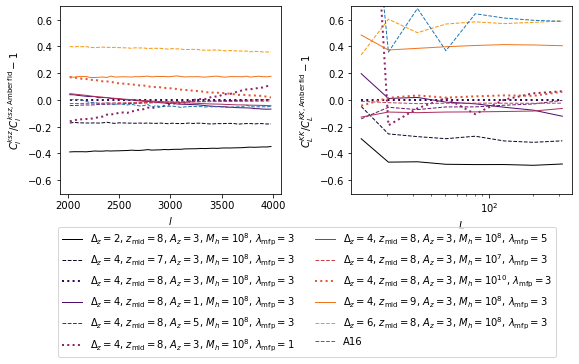

In [21]:
%matplotlib inline

binner = ClBinner(lmin=10, lmax=400, nbin=8, log=True)
binner_2pt = ClBinner(lmin=2000, lmax=4000, nbin=50)

fig,axs=plt.subplots(ncols=2, figsize=(8,5))
ax_2pt,ax = axs
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="linear"
linthreshy=0.5
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=False
plot_meanfield_correction=False
lpower=0
plot_raw_auto=False
plot_mcn0=False
do_one_leg_cleaned=False
plot_meanfield=False
ylim=[-0.7,0.7]
ylim_2pt=[-0.7,0.7]
#ylim=None
divide_by_uL2=False
frac_diff_to_alvarez=False
frac_diff_to_fid = True
plot_alvarez=True



#d_qe = "/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v7000_lmax5000_mask60sk_gausssims/"
#plot_clKK(ax, d_qe, 
#           binner, mask_60sk_file, color='C0', rdn0_file=opj(d_qe,"rdn0_outputs_nsim32.pkl"),
#           label="hILC, lmax=5000",  
#           yscale=yscale,  lpower=lpower,
#           meanfield_dir=opj(d_qe,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
#           offsets = offsets[0], est="qe", divide_by_uL2=divide_by_uL2,
#           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
#           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
#           plot_meanfield_correction=plot_meanfield_correction,
#             sim_CLKKs_file="../sim_e2e_test/output_auto_config_lmax5000_actonly_hilc_hilc_hilc_hilc_CLKKs_nsim128.npy") #, u_L=u_L)    

#Get Alvarez prediction 
#clkk_stuff = get_CLKK_stuff("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v4_v4_lmax5000_mask60sk_gausssims/", 
#                            "mean_field_nsim64", "rdn0_outputs_nsim64.pkl", w1, w4, binner, use_mcn0=False,
#                            est="qe", divide_by_uL2=False)
#CLKK_binned_alvarez = cl_kk_stuff["CL_KK_ksz_theory_binned"]
#I assume: z = z_mid (redshift of 50% reionization)
#          D = Delta_z (duration between 5 and 95% reionization)
#          A = A_z (assymetry parameter, >1 if early reionization takes longer)
#          M = M_h (minimum halo mass for hosting ionizing sources, in M_sun
#          l = lambda_mfp (mean free path for photon flux, in Mpc/h)
amber_label_dict={
 "output_z=8.00_D=2.00_A=3.00_M=1E8_l=3.00" : r"$\Delta_z = 2$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=7.00_D=4.00_A=3.00_M=1E8_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 7$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=3.00_M=1E8_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=1.00_M=1E8_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 1$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=5.00_M=1E8_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 5$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=3.00_M=1E8_l=1.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 1$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=3.00_M=1E8_l=5.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 5$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=3.00_M=1E7_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^7$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=4.00_A=3.00_M=1E10_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^{10}$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=9.00_D=4.00_A=3.00_M=1E8_l=3.00" : r"$\Delta_z = 4$, $z_{\mathrm{mid}} = 9$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
 "output_z=8.00_D=6.00_A=3.00_M=1E8_l=3.00" : r"$\Delta_z = 6$, $z_{\mathrm{mid}} = 8$, $A_z = 3$, $M_h = 10^8$, $\lambda_{\mathrm{mfp}} = 3$", # $\mathrm{Mpc}/h$",
}
amber_fid_key = "output_z=8.00_D=4.00_A=3.00_M=1E8_l=3.00"

#ooh we could also plot the amber predictions here...
with open("/global/cfs/projectdirs/act/data/maccrann/amber_Ks/amber_Ks_22.02.24/amber_auto_data_test.pkl", "rb") as f:
    amber_prediction_data = pickle.load(f)
amber_keys = list(amber_prediction_data.keys())
n_amber = len(amber_prediction_data.keys())
from matplotlib import cm
amber_colors = [cm.inferno(x) for x in np.linspace(0, 1., n_amber+1)]
print(amber_colors)
amber_color="C5"
amber_all_cls = np.zeros((n_amber, binner.nbin))
linestyles=["-","--",":"]*10
lws=[1.,1.,2.]*10
for i,(key,c) in enumerate(zip(amber_label_dict.keys(), amber_colors)):

    CL_KK = amber_prediction_data[key]["CL_KK"][:binner.lmax+1]
    #profile = amber_prediction_data[key]["profile"][:binner.lmax+1]
    if frac_diff_to_fid:
        CL_KK = CL_KK.copy() / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1
    elif frac_diff_to_alvarez:
        #print(CL_KK / amber_prediction_data["CL_KK_alvarez"][:binner.lmax+1])
        CL_KK = CL_KK / amber_prediction_data["CL_KK_alvarez"][:binner.lmax+1] - 1   
    elif divide_by_uL2:
        CL_KK /= profile**2
    
    ax.plot(binner.bin_mids, binner(
        np.arange(binner.lmax+1)**lpower*CL_KK),
            "-", color=amber_colors[i], label=amber_label_dict[key], linestyle=linestyles[i], linewidth=lws[i])
    
    #Also plot 2pt
    Cl_ksz = amber_prediction_data[key]["Cl_ksz"]
    ax_2pt.plot(binner_2pt.bin_mids, binner_2pt(Cl_ksz)/binner_2pt(amber_prediction_data[amber_fid_key]["Cl_ksz"])-1,
             "-", color=amber_colors[i], linestyle=linestyles[i], linewidth=lws[i])
    
    #if u_L is not None:
    #    ax.plot(binner.bin_mids, 
    #            binner(np.arange(binner.lmax+1)**lpower*CL_KK[:binner.lmax+1]/u_L[:binner.lmax+1]**2), 
    #            "-", color=amber_color)
    #else:
    #    ax.plot(binner.bin_mids, binner(np.arange(binner.lmax+1)**lpower*CL_KK[:binner.lmax+1]), "-", color=amber_color)
    
if plot_alvarez:
    if frac_diff_to_fid:
        CL_KK_ratio = binner(amber_prediction_data["CL_KK_alvarez"][:binner.lmax+1])/binner(
            amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1]) - 1
        ax.plot(binner.bin_mids, CL_KK_ratio,
                "--", linewidth=1., color="C0", label="A16")
        ax_2pt.plot(binner_2pt.bin_mids,
            binner_2pt(amber_prediction_data["Cl_ksz_alvarez"])/binner_2pt(amber_prediction_data[key]["Cl_ksz"])-1,
                "--", linewidth=1., color="C0")

        
        
    
#if frac_diff_to_fid:
#    ax.plot(binner.bin_mids, binner( amber_prediction_data["CL_KK_alvarez"][:binner.lmax+1] / amber_prediction_data[amber_fid_key]["CL_KK"][:binner.lmax+1] - 1), 
#            "-", color="k", alpha=0.5, label="A16")
    
amber_range = (np.min(amber_all_cls, axis=0), np.max(amber_all_cls, axis=0))
print("amber_range:",amber_range)
#ax.fill_between(binner.bin_mids, amber_range[0], amber_range[1], color=amber_color)

ax.set_xscale('log')
if yscale=="symlog":
    ax.set_yscale(yscale, linthreshy=linthreshy)
else:
    ax.set_yscale(yscale)
ax.set_xlabel(r"$L$")
ax_2pt.set_xlabel(r"$l$")


if frac_diff_to_fid:
    ylabel = r"$C_L^{KK} / C_L^{KK, \mathrm{Amber \, fid}}-1$"
elif frac_diff_to_alvarez:
    ylabel = r"$C_L^{KK} / C_L^{KK, \mathrm{A15}}-1$"
elif lpower!=0:
    ylabel = r"$L^{%d}C_L^{KK}$"%lpower
else:
    ylabel= r"$C_L^{KK}$"
ax.set_ylabel(ylabel)
ax_2pt.set_ylabel(r"$C_l^{ksz} / C_l^{ksz, \mathrm{Amber \, fid}}-1$")
    
if ylim is not None:
    ax.set_ylim(ylim)
if ylim_2pt is not None:
    ax_2pt.set_ylim(ylim)
    


    
fig.tight_layout()
plt.subplots_adjust(bottom=0.45, right=1.)
lg=ax.legend(loc='upper center', bbox_to_anchor=(-0.2, -0.15), ncol=2)
#plt.subplots_adjust(right=0.35, left=0.1, bottom=0.1)
#filename="CLKK_dr6_biases_hilc.png"
filename="amber_theory.png"
fig.savefig(filename, dpi=300, bbox_extra_artists=(lg,))

## There seems to be an issue with lmax=6000 (nans)

In [65]:
alm = hp.read_alm("/pscratch/sd/m/maccrann/cmb/act_dr6/kcoadd_f_090_lmax7000_v4_70mask_v1_split0.fits")
print(np.any(np.isnan(alm)))

False


0.00033248538954838144


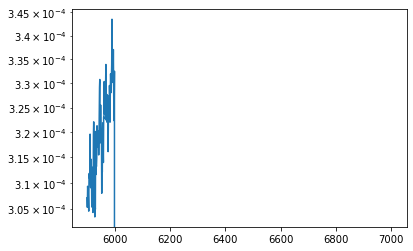

In [72]:
%matplotlib inline

cl = curvedsky.alm2cl(alm)
print(cl[5999])
fig,ax=plt.subplots()
ells = np.arange(len(cl))
ax.plot(ells[5900:],cl[5900:])
ax.set_yscale('log')

## check multiple sims

In [6]:
mask_60sk_file = "/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_60.00sk.fits"
mask = enmap.read_map(mask_60sk_file)
w1 = maps.wfactor(1,mask)
w4 = maps.wfactor(4,mask)

In [88]:
## Show lensing-hardening

In [39]:

def get_clkks(d, binner, nsim, meanfield_dir, rdn0_file, est):
    amps = []
    cl_kks = []
    cl_kks_binned = []
    frac_diffs_binned = []
    nsim_read=0
    meanfield_dir=opj(d, "output_rot0", meanfield_dir)
    rdn0_file=opj(d, "output_rot0", rdn0_file)
    for irot in range(nsim):
        print("isim:",irot)
        di=opj(d, "output_rot%d"%irot)
        try:
            with open(opj(di, "auto_outputs.pkl"), "rb") as f:
                pickle.load(f)
        except Exception as e:
            print(e)
            print("skipping irot=%d"%irot)
            continue
        nsim_read+=1

        cl_kk_stuff = get_CLKK_stuff(
                di, meanfield_dir, rdn0_file, w1, w4, binner, use_mcn0=True,
                est=est
        )
        cl_kks_binned.append(cl_kk_stuff["CL_KK_binned"])
        frac_diffs_binned.append( cl_kk_stuff["CL_KK_binned"] / cl_kk_stuff["CL_KK_ksz_theory_binned"] - 1. )
        amps.append(cl_kk_stuff["A_ksz"])
    return np.array(cl_kks_binned), np.array(frac_diffs_binned), np.array(amps)

In [40]:
d6000 = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc"
cl_kks_qe, frac_diffs_qe, amps_qe = get_clkks(d6000, binner, 10, "mean_field_nsim64", "rdn0_outputs_nsim32.pkl", "qe")

isim: 0
est: qe
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot0/K_ab.npy, will try .pkl instead
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot0/K_cd.npy, will try .pkl instead
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32
isim: 1
est: qe
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot1/K_ab.npy, will try .pkl instead
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot1/K_cd.npy, will try .pkl 

In [41]:
d6000_lh = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc"
cl_kks_lh, frac_diffs_lh, amps_lh = get_clkks(d6000_lh, binner, 10, "mean_field_nsim64_lh", "rdn0_outputs_lh_nsim32.pkl", "lh")

isim: 0
est: lh
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot0/K_ab_lh.npy, will try .pkl instead
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot0/K_cd_lh.npy, will try .pkl instead
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot0/mean_field_nsim64_lh
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot0/rdn0_outputs_lh_nsim32.pkl
32
isim: 1
est: lh
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot1/K_ab_lh.npy, will try .pkl instead
didn't find /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/out

In [43]:
print(amps_qe)
print(amps_lh)

[6.84134153 7.18877543 6.5738838  6.80358639 6.60921105 7.0384037
 6.03734985 7.30998915 6.86714658 6.77754666]
[1.52487249 2.14322555 1.63109766 1.84191364 1.84945881 1.78322226
 1.67427966 1.80158902 1.82082668 1.47920514]


(10, 8)
[  6.70820393  11.22497216  18.33030278  30.59411708  50.3487835
  83.78544026 139.42740046 232.37900077]
[15.98996242 -6.31600285  0.7003583  -0.28017388  0.69755167  0.37227654
  1.26481333  4.57195412]
[0.541662   0.34066321 0.14725377 0.12307395 0.08949303 0.09509159
 0.08719384 0.19342912]


(-1.0, 20.0)

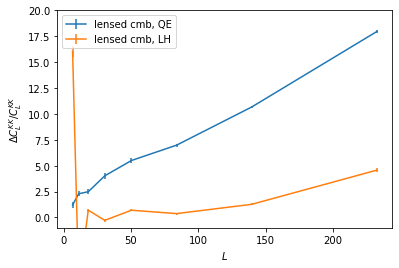

In [45]:
%matplotlib inline

fig,ax=plt.subplots()

print(frac_diffs_lh.shape)
print(binner.bin_mids)
print(frac_diffs_lh.mean(axis=0))
print(np.std(frac_diffs_lh, axis=0)/np.sqrt(len(frac_diffs_qe)))

ax.errorbar(binner.bin_mids, frac_diffs_qe.mean(axis=0), yerr=np.std(frac_diffs_qe, axis=0)/np.sqrt(len(frac_diffs_qe)), label="lensed cmb, QE")
ax.errorbar(binner.bin_mids, frac_diffs_lh.mean(axis=0), yerr=np.std(frac_diffs_lh, axis=0)/np.sqrt(len(frac_diffs_lh)), label="lensed cmb, LH")

ax.legend()
ax.set_yscale("linear")
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{KK} / C_L^{KK}$")
ax.set_ylim([-1, 20])

In [ ]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, figsize=(8,4))
nsim=128
tag="output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc"
d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/"+tag+"/output_rot%d"
amps, A_mean, A_err, cl_kks = plot_e2e_sims(axs, d,            
              opj(d%0,"mean_field_nsim64"),
              opj(d%0,"rdn0_outputs_nsim32.pkl"), 
              binner, est="qe", nsim=nsim)
fig.tight_layout()
fig.savefig("e2e_lmax5000_actonly.png",dpi=300)

#also save amplitude data
amp_data = {"A_mean":A_mean, "A_err":A_err, "As":amps}
with open(opj("amp_data", "%s_nsim%d.pkl"%(tag,nsim)), "wb") as f:
    pickle.dump(amp_data, f)
np.save("%s_CLKKs_nsim%d.npy"%(tag, nsim), cl_kks)

isim: 0
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2908.933289 +/- 3.903480
binned A_ksz = 4032.071884 +/- 4.040626
isim: 1
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 601.527899 +/- 3.873605
binned A_ksz = 1284.796753 +/- 4.009649
isim: 2
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1737.177334 +/- 3.864748
binned A_ksz = 1936.822147 +/- 4.000419
isim: 3
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1121.339396 +/- 3.863669
binned A_ksz = 1441.625149 +/- 3.999226
isim: 4
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1893.940493 +/- 3.869291
binned A_ksz = 2281.229981 +/- 4.005118
isim: 5
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 654.183572 +/- 3.865267
binned A_ksz = 1312.080979 +/- 4.000991
isim: 6
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1105.756808 +/- 3.858249
binned A_ksz = 1822.439395 +/- 3.993624
isim: 7
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 405.923140 +/- 3.855883
binned A_ksz = 914.723621 +/- 3.991236
isim: 8
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 774.615894 +/- 3.850002
binned A_ksz = 1417.892535 +/- 3.985077
isim: 9
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 751.031890 +/- 3.874168
binned A_ksz = 952.234802 +/- 4.010146
isim: 10
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1000.615904 +/- 3.859177
binned A_ksz = 1945.232849 +/- 3.994654
isim: 11
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 587.410402 +/- 3.857692
binned A_ksz = 1052.705950 +/- 3.993122
isim: 12
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 966.203675 +/- 3.860051
binned A_ksz = 1197.344819 +/- 3.995449
isim: 13
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1716.626405 +/- 3.850209
binned A_ksz = 2105.932003 +/- 3.985305
isim: 14
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 942.838625 +/- 3.859916
binned A_ksz = 885.478910 +/- 3.995384
isim: 15
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 461.603821 +/- 3.864991
binned A_ksz = 1267.355873 +/- 4.000638
isim: 16
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1012.911753 +/- 3.874398
binned A_ksz = 1537.441154 +/- 4.010425
isim: 17
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 903.615913 +/- 3.866319
binned A_ksz = 1605.888070 +/- 4.001896
isim: 18
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1589.151476 +/- 3.884674
binned A_ksz = 2576.151879 +/- 4.021060
isim: 19
est: qe
reading meanfield from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/mean_field_nsim64
reading rdn0 from /pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc-tszandcibd_hilc_hilc/output_rot0/rdn0_outputs_nsim32.pkl
32


/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:228: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(np.diag(CL_KK_cov_use))[:binner.lmax+1]
/global/u1/m/maccrann/cmb/ksz2/plots/plot_tools.py:230: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 454.820863 +/- 3.852161
binned A_ksz = 500.118604 +/- 3.987403
isim: 20


isim: 0
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.447041 +/- 3.432918
binned A_ksz = -1.856140 +/- 3.554255
isim: 1
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.915848 +/- 3.425093
binned A_ksz = 11.741427 +/- 3.546140
isim: 2
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.574355 +/- 3.428311
binned A_ksz = 18.856550 +/- 3.549435
isim: 3
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.676113 +/- 3.429260
binned A_ksz = 29.026984 +/- 3.550414
isim: 4
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.887628 +/- 3.424981
binned A_ksz = 23.660778 +/- 3.545943
isim: 5
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.329732 +/- 3.436602
binned A_ksz = -0.148442 +/- 3.558105
isim: 6
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.727106 +/- 3.433426
binned A_ksz = 31.987077 +/- 3.554711
isim: 7
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.136069 +/- 3.430670
binned A_ksz = 20.275927 +/- 3.551905
isim: 8
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 24.870110 +/- 3.427110
binned A_ksz = 26.382083 +/- 3.548180
isim: 9
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.075620 +/- 3.428803
binned A_ksz = 6.604162 +/- 3.549954
isim: 10
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.770956 +/- 3.430030
binned A_ksz = 3.010128 +/- 3.551264
isim: 11
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.074092 +/- 3.424903
binned A_ksz = -5.391948 +/- 3.545979
isim: 12
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.446015 +/- 3.427356
binned A_ksz = 2.946686 +/- 3.548436
isim: 13
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 15.547165 +/- 3.426134
binned A_ksz = 17.698168 +/- 3.547159
isim: 14
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.553426 +/- 3.425141
binned A_ksz = 6.940157 +/- 3.546155
isim: 15
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.407578 +/- 3.425343
binned A_ksz = 9.468487 +/- 3.546360
isim: 16
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.059266 +/- 3.427072
binned A_ksz = -3.020266 +/- 3.548176
isim: 17
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.120823 +/- 3.426318
binned A_ksz = 4.989402 +/- 3.547288
isim: 18
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.161871 +/- 3.437713
binned A_ksz = 21.202330 +/- 3.559205
isim: 19
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.541967 +/- 3.422304
binned A_ksz = 3.943212 +/- 3.543261
isim: 20
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.243437 +/- 3.428862
binned A_ksz = 4.988526 +/- 3.550062
isim: 21
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.572897 +/- 3.424406
binned A_ksz = 28.653131 +/- 3.545390
isim: 22
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.567659 +/- 3.430743
binned A_ksz = -3.524400 +/- 3.552020
isim: 23
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.630731 +/- 3.436206
binned A_ksz = -4.143572 +/- 3.557646
isim: 24
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.816745 +/- 3.433733
binned A_ksz = 6.292918 +/- 3.555078
isim: 25
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.672995 +/- 3.434633
binned A_ksz = 6.560393 +/- 3.556025
isim: 26
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.548751 +/- 3.430349
binned A_ksz = 13.224601 +/- 3.551606
isim: 27
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.223443 +/- 3.428801
binned A_ksz = 14.578889 +/- 3.549954
isim: 28
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.942462 +/- 3.425785
binned A_ksz = -4.277743 +/- 3.546796
isim: 29
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.160302 +/- 3.417437
binned A_ksz = 6.304034 +/- 3.538169
isim: 30
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.681762 +/- 3.431663
binned A_ksz = 5.898384 +/- 3.552854
isim: 31
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 32.770534 +/- 3.422672
binned A_ksz = 33.230064 +/- 3.543589
isim: 32
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.401068 +/- 3.430529
binned A_ksz = 11.484006 +/- 3.551756
isim: 33
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 15.202278 +/- 3.419020
binned A_ksz = 16.851225 +/- 3.539809
isim: 34
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 28.712537 +/- 3.440267
binned A_ksz = 28.693843 +/- 3.561829
isim: 35
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.567991 +/- 3.427647
binned A_ksz = -6.311025 +/- 3.548788
isim: 36
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 36.714722 +/- 3.422669
binned A_ksz = 35.229002 +/- 3.543607
isim: 37
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 11.066042 +/- 3.437061
binned A_ksz = 12.472932 +/- 3.558547
isim: 38
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 13.072905 +/- 3.432170
binned A_ksz = 14.556371 +/- 3.553456
isim: 39
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.753786 +/- 3.437609
binned A_ksz = 13.336799 +/- 3.559133
isim: 40
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 24.372667 +/- 3.405873
binned A_ksz = 26.887595 +/- 3.526100
isim: 41
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.251983 +/- 3.430518
binned A_ksz = -0.400997 +/- 3.551755
isim: 42
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -9.793442 +/- 3.430190
binned A_ksz = -9.753662 +/- 3.551404
isim: 43
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.728965 +/- 3.422648
binned A_ksz = -1.494532 +/- 3.543637
isim: 44
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 40.388211 +/- 3.439019
binned A_ksz = 41.198158 +/- 3.560544
isim: 45
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.589502 +/- 3.419007
binned A_ksz = 3.639836 +/- 3.539790
isim: 46
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.023502 +/- 3.421687
binned A_ksz = 33.403571 +/- 3.542534
isim: 47
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.483603 +/- 3.425788
binned A_ksz = 10.405889 +/- 3.546787
isim: 48
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.819557 +/- 3.431985
binned A_ksz = 19.900312 +/- 3.553291
isim: 49
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.788628 +/- 3.431816
binned A_ksz = 21.175187 +/- 3.553124
isim: 50
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 32.038789 +/- 3.426409
binned A_ksz = 31.663688 +/- 3.547473
isim: 51
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.143491 +/- 3.435846
binned A_ksz = 16.047684 +/- 3.557258
isim: 52
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.782876 +/- 3.437160
binned A_ksz = 3.190077 +/- 3.558621
isim: 53
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.937165 +/- 3.418781
binned A_ksz = 18.590706 +/- 3.539573
isim: 54
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 29.386884 +/- 3.427836
binned A_ksz = 28.346174 +/- 3.548987
isim: 55
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.004447 +/- 3.432709
binned A_ksz = -5.599018 +/- 3.554046
isim: 56
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 12.601173 +/- 3.435357
binned A_ksz = 12.087791 +/- 3.556781
isim: 57
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.196319 +/- 3.425094
binned A_ksz = -0.385347 +/- 3.546124
isim: 58
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -5.314143 +/- 3.435157
binned A_ksz = -3.682969 +/- 3.556571
isim: 59
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.420927 +/- 3.427304
binned A_ksz = 9.428008 +/- 3.548437
isim: 60
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.360372 +/- 3.430307
binned A_ksz = 9.362543 +/- 3.551520
isim: 61
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.065514 +/- 3.422479
binned A_ksz = 29.433800 +/- 3.543315
isim: 62
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.498295 +/- 3.424398
binned A_ksz = 15.635086 +/- 3.545434
isim: 63
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.072153 +/- 3.442943
binned A_ksz = 8.454154 +/- 3.564610
isim: 64
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.969932 +/- 3.418234
binned A_ksz = 12.242886 +/- 3.538984
isim: 65
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.863091 +/- 3.430211
binned A_ksz = 15.886069 +/- 3.551431
isim: 66
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.646962 +/- 3.420850
binned A_ksz = 20.016949 +/- 3.541710
isim: 67
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.611030 +/- 3.439741
binned A_ksz = -9.119007 +/- 3.561319
isim: 68
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.000820 +/- 3.435292
binned A_ksz = 5.182198 +/- 3.556712
isim: 69
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 21.165028 +/- 3.416168
binned A_ksz = 23.794835 +/- 3.536803
isim: 70
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 28.699913 +/- 3.422794
binned A_ksz = 31.225806 +/- 3.543715
isim: 71
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.281470 +/- 3.434615
binned A_ksz = 0.204217 +/- 3.555983
isim: 72
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 5.458703 +/- 3.428513
binned A_ksz = 10.479468 +/- 3.549633
isim: 73
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.698698 +/- 3.430937
binned A_ksz = 4.836111 +/- 3.552197
isim: 74
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 31.138081 +/- 3.431032
binned A_ksz = 31.586927 +/- 3.552278
isim: 75
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.552113 +/- 3.431351
binned A_ksz = 7.247522 +/- 3.552669
isim: 76
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.973404 +/- 3.426162
binned A_ksz = 6.804872 +/- 3.547253
isim: 77
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -6.761931 +/- 3.418919
binned A_ksz = -7.082143 +/- 3.539697
isim: 78
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 13.673741 +/- 3.425263
binned A_ksz = 16.760566 +/- 3.546286
isim: 79
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.578876 +/- 3.437469
binned A_ksz = 13.422430 +/- 3.558985
isim: 80
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -0.217528 +/- 3.427435
binned A_ksz = 2.037021 +/- 3.548588
isim: 81
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 11.564826 +/- 3.422880
binned A_ksz = 7.736156 +/- 3.543779
isim: 82
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 15.523830 +/- 3.426156
binned A_ksz = 15.048697 +/- 3.547243
isim: 83
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 5.577138 +/- 3.439110
binned A_ksz = 9.148862 +/- 3.560685
isim: 84
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.559542 +/- 3.429654
binned A_ksz = -4.767816 +/- 3.550865
isim: 85
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 28.243617 +/- 3.429261
binned A_ksz = 27.544103 +/- 3.550446
isim: 86
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 28.677719 +/- 3.419887
binned A_ksz = 29.819519 +/- 3.540724
isim: 87
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -18.801519 +/- 3.421653
binned A_ksz = -17.751919 +/- 3.542570
isim: 88
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 12.057030 +/- 3.427549
binned A_ksz = 11.077856 +/- 3.548662
isim: 89
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.090332 +/- 3.420924
binned A_ksz = 22.076878 +/- 3.541792
isim: 90
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 13.752775 +/- 3.430898
binned A_ksz = 13.172642 +/- 3.552120
isim: 91
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.026731 +/- 3.433264
binned A_ksz = 5.525153 +/- 3.554558
isim: 92
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.532198 +/- 3.428921
binned A_ksz = -3.324428 +/- 3.550113
isim: 93
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.420074 +/- 3.431325
binned A_ksz = 9.434348 +/- 3.552574
isim: 94
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -6.137474 +/- 3.426562
binned A_ksz = -5.475149 +/- 3.547695
isim: 95
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.015785 +/- 3.437097
binned A_ksz = 7.432907 +/- 3.558579
isim: 96
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -22.366850 +/- 3.433842
binned A_ksz = -28.269814 +/- 3.555186
isim: 97
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.454326 +/- 3.428795
binned A_ksz = -1.679081 +/- 3.549902
isim: 98
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.539308 +/- 3.443119
binned A_ksz = 6.618219 +/- 3.564799
isim: 99
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.149916 +/- 3.424047
binned A_ksz = 21.569940 +/- 3.545049
isim: 100
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.577500 +/- 3.422267
binned A_ksz = -2.918456 +/- 3.543183
isim: 101
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 23.036353 +/- 3.420247
binned A_ksz = 23.224865 +/- 3.541030
isim: 102
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.813174 +/- 3.420762
binned A_ksz = 29.107308 +/- 3.541660
isim: 103
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.839067 +/- 3.429774
binned A_ksz = 0.059519 +/- 3.551017
isim: 104
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.902275 +/- 3.437642
binned A_ksz = -7.347787 +/- 3.559165
isim: 105
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.263585 +/- 3.415752
binned A_ksz = 4.664073 +/- 3.536421
isim: 106
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.330537 +/- 3.424126
binned A_ksz = 17.823895 +/- 3.545104
isim: 107
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 29.959966 +/- 3.433432
binned A_ksz = 33.668077 +/- 3.554752
isim: 108
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.267459 +/- 3.430953
binned A_ksz = 20.658116 +/- 3.552217
isim: 109
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -11.078289 +/- 3.423966
binned A_ksz = -12.922749 +/- 3.544917
isim: 110
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 3.643491 +/- 3.414505
binned A_ksz = 5.486490 +/- 3.535079
isim: 111
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.443736 +/- 3.421126
binned A_ksz = 8.776929 +/- 3.542004
isim: 112
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 27.499583 +/- 3.438559
binned A_ksz = 29.011375 +/- 3.560184
isim: 113
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.241145 +/- 3.418690
binned A_ksz = 7.904362 +/- 3.539492
isim: 114
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 23.100272 +/- 3.429058
binned A_ksz = 23.942791 +/- 3.550240
isim: 115
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 12.924418 +/- 3.429401
binned A_ksz = 15.635982 +/- 3.550553
isim: 116
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 37.690677 +/- 3.432433
binned A_ksz = 35.573383 +/- 3.553769
isim: 117
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.033944 +/- 3.437085
binned A_ksz = 21.382645 +/- 3.558546
isim: 118
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.371977 +/- 3.417777
binned A_ksz = -1.833819 +/- 3.538498
isim: 119
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.906151 +/- 3.421267
binned A_ksz = 5.636480 +/- 3.542155
isim: 120
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 38.005533 +/- 3.423297
binned A_ksz = 40.507657 +/- 3.544261
isim: 121
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.735908 +/- 3.426524
binned A_ksz = 10.907638 +/- 3.547629
isim: 122
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.011439 +/- 3.415514
binned A_ksz = 9.064217 +/- 3.536147
isim: 123
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.865514 +/- 3.440027
binned A_ksz = 7.882388 +/- 3.561666
isim: 124
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -0.105588 +/- 3.431831
binned A_ksz = -1.155874 +/- 3.553133
isim: 125
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.002474 +/- 3.428392
binned A_ksz = 6.911419 +/- 3.549585
isim: 126
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.088510 +/- 3.414348
binned A_ksz = 2.353360 +/- 3.534889
isim: 127
est: qe
32


/tmp/ipykernel_599979/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_599979/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.217398 +/- 3.431142
binned A_ksz = 9.320061 +/- 3.552361


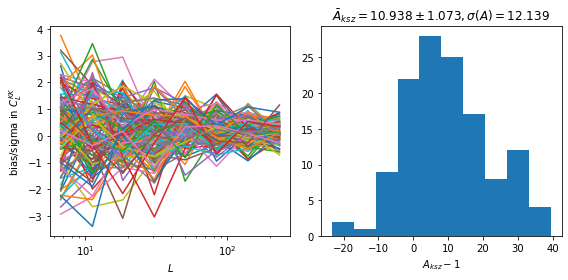

isim: 0
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -14.918984 +/- 4.468555
binned A_ksz = -14.648527 +/- 4.628488
isim: 1
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 10.292778 +/- 4.465279
binned A_ksz = 11.755643 +/- 4.625074
isim: 2
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 22.799821 +/- 4.470388
binned A_ksz = 23.366433 +/- 4.630361
isim: 3
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 5.305119 +/- 4.474125
binned A_ksz = 6.157053 +/- 4.634204
isim: 4
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 16.141872 +/- 4.463830
binned A_ksz = 19.986815 +/- 4.623503
isim: 5
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -23.895800 +/- 4.480379
binned A_ksz = -27.977911 +/- 4.640799
isim: 6
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 35.719595 +/- 4.477239
binned A_ksz = 33.003563 +/- 4.637423
isim: 7
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.568202 +/- 4.468711
binned A_ksz = 0.696453 +/- 4.628641
isim: 8
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.643401 +/- 4.467137
binned A_ksz = 5.520474 +/- 4.627019
isim: 9
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.036933 +/- 4.474335
binned A_ksz = 21.934935 +/- 4.634397
isim: 10
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.577140 +/- 4.470678
binned A_ksz = 0.193221 +/- 4.630674
isim: 11
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -25.566351 +/- 4.461949
binned A_ksz = -29.005625 +/- 4.621611
isim: 12
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -14.498324 +/- 4.468593
binned A_ksz = -10.840721 +/- 4.628479
isim: 13
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.434222 +/- 4.473390
binned A_ksz = 12.406767 +/- 4.633471
isim: 14
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.750323 +/- 4.455706
binned A_ksz = 0.058125 +/- 4.615186
isim: 15
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.259399 +/- 4.468384
binned A_ksz = -0.708156 +/- 4.628246
isim: 16
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.355722 +/- 4.464312
binned A_ksz = -6.067909 +/- 4.624090
isim: 17
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.101539 +/- 4.462111
binned A_ksz = 20.118970 +/- 4.621630
isim: 18
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -0.482343 +/- 4.481401
binned A_ksz = 4.082934 +/- 4.641848
isim: 19
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.748404 +/- 4.468567
binned A_ksz = 7.515706 +/- 4.628518
isim: 20
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.556089 +/- 4.469388
binned A_ksz = 13.744408 +/- 4.629330
isim: 21
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 3.497925 +/- 4.463588
binned A_ksz = 4.395574 +/- 4.623302
isim: 22
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -9.674740 +/- 4.471628
binned A_ksz = -12.122750 +/- 4.631726
isim: 23
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.464330 +/- 4.479124
binned A_ksz = -5.718254 +/- 4.639434
isim: 24
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.458103 +/- 4.477267
binned A_ksz = -1.784340 +/- 4.637494
isim: 25
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.459983 +/- 4.475374
binned A_ksz = -6.703621 +/- 4.635596
isim: 26
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -16.684187 +/- 4.482127
binned A_ksz = -12.866551 +/- 4.642591
isim: 27
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.063623 +/- 4.471383
binned A_ksz = 19.170453 +/- 4.631445
isim: 28
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -7.403375 +/- 4.470765
binned A_ksz = -7.195272 +/- 4.630770
isim: 29
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -9.189517 +/- 4.466512
binned A_ksz = -12.747973 +/- 4.626357
isim: 30
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.589727 +/- 4.473888
binned A_ksz = 13.594446 +/- 4.633896
isim: 31
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 33.272839 +/- 4.466119
binned A_ksz = 36.376044 +/- 4.625897
isim: 32
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -9.907535 +/- 4.466561
binned A_ksz = -16.858647 +/- 4.626397
isim: 33
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.173844 +/- 4.467108
binned A_ksz = 8.397068 +/- 4.626980
isim: 34
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.575991 +/- 4.470901
binned A_ksz = 16.476691 +/- 4.630839
isim: 35
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -20.466701 +/- 4.456054
binned A_ksz = -25.387718 +/- 4.615496
isim: 36
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.122564 +/- 4.467598
binned A_ksz = 4.470941 +/- 4.627455
isim: 37
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -0.215270 +/- 4.470820
binned A_ksz = -1.262988 +/- 4.630820
isim: 38
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 29.719471 +/- 4.463672
binned A_ksz = 31.773290 +/- 4.623357
isim: 39
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.446587 +/- 4.477022
binned A_ksz = 11.525190 +/- 4.637266
isim: 40
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.043200 +/- 4.453171
binned A_ksz = 14.621880 +/- 4.612452
isim: 41
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.867201 +/- 4.474327
binned A_ksz = 21.020830 +/- 4.634466
isim: 42
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -21.822762 +/- 4.466913
binned A_ksz = -24.165329 +/- 4.626792
isim: 43
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -14.860617 +/- 4.455507
binned A_ksz = -18.155740 +/- 4.615053
isim: 44
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 40.382461 +/- 4.489175
binned A_ksz = 42.602391 +/- 4.649818
isim: 45
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.305114 +/- 4.461109
binned A_ksz = 1.918660 +/- 4.620739
isim: 46
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 13.987865 +/- 4.460533
binned A_ksz = 16.292511 +/- 4.620084
isim: 47
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -12.819157 +/- 4.461795
binned A_ksz = -13.864723 +/- 4.621404
isim: 48
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.800767 +/- 4.464885
binned A_ksz = 18.593879 +/- 4.624631
isim: 49
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 11.641111 +/- 4.473631
binned A_ksz = 14.756001 +/- 4.633769
isim: 50
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 27.218774 +/- 4.467973
binned A_ksz = 26.678610 +/- 4.627860
isim: 51
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 5.992079 +/- 4.474717
binned A_ksz = 6.821352 +/- 4.634854
isim: 52
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.094330 +/- 4.484914
binned A_ksz = -1.477694 +/- 4.645425
isim: 53
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.936768 +/- 4.459660
binned A_ksz = 4.968606 +/- 4.619220
isim: 54
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.126194 +/- 4.464313
binned A_ksz = 16.678932 +/- 4.624075
isim: 55
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -5.786271 +/- 4.475003
binned A_ksz = -5.162378 +/- 4.635211
isim: 56
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.677854 +/- 4.480254
binned A_ksz = 22.908144 +/- 4.640645
isim: 57
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -5.668212 +/- 4.477231
binned A_ksz = -7.522493 +/- 4.637499
isim: 58
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -39.553835 +/- 4.476933
binned A_ksz = -40.446975 +/- 4.637212
isim: 59
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.860627 +/- 4.476257
binned A_ksz = 0.446680 +/- 4.636503
isim: 60
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -12.752903 +/- 4.466519
binned A_ksz = -12.705199 +/- 4.626330
isim: 61
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.108124 +/- 4.465204
binned A_ksz = 14.469232 +/- 4.624917
isim: 62
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.959575 +/- 4.455248
binned A_ksz = 5.850838 +/- 4.614680
isim: 63
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -33.183019 +/- 4.478238
binned A_ksz = -33.080273 +/- 4.638497


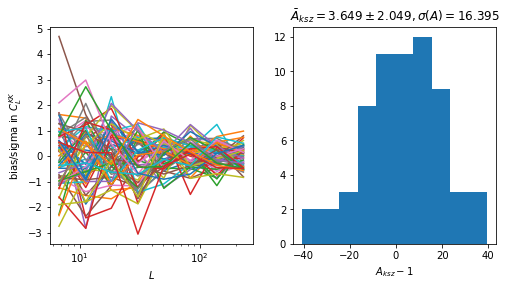

In [91]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, figsize=(8,4))


d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_actonly_unlensedsim_hilc_hilc_hilc_hilc/output_rot%d"
plot_e2e_sims(axs, d,            
              opj(d%0,"mean_field_nsim64"),
              opj(d%0,"rdn0_outputs_nsim32.pkl"), 
              binner, est="qe", nsim=64)
fig.tight_layout()
fig.savefig("e2e_lmax5000_actonly_unlensed.png",dpi=300)

isim: 0
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.841342 +/- 4.416527
binned A_ksz = 7.163111 +/- 4.574773
isim: 1
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.188775 +/- 4.416527
binned A_ksz = 7.491598 +/- 4.574773
isim: 2
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.573884 +/- 4.416527
binned A_ksz = 6.868261 +/- 4.574773
isim: 3
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.803586 +/- 4.416527
binned A_ksz = 7.092981 +/- 4.574773
isim: 4
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.609210 +/- 4.416527
binned A_ksz = 6.903818 +/- 4.574773
isim: 5
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.038404 +/- 4.416527
binned A_ksz = 7.303702 +/- 4.574773
isim: 6
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.037349 +/- 4.416527
binned A_ksz = 6.327547 +/- 4.574773
isim: 7
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.309990 +/- 4.416527
binned A_ksz = 7.675297 +/- 4.574773
isim: 8
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.867146 +/- 4.416527
binned A_ksz = 7.139094 +/- 4.574773
isim: 9
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.777547 +/- 4.416527
binned A_ksz = 7.099338 +/- 4.574773
isim: 10
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.658055 +/- 4.416527
binned A_ksz = 6.920757 +/- 4.574773
isim: 11
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.804233 +/- 4.416527
binned A_ksz = 7.096088 +/- 4.574773
isim: 12
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.580135 +/- 4.416527
binned A_ksz = 6.937722 +/- 4.574773
isim: 13
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.153431 +/- 4.416527
binned A_ksz = 7.516735 +/- 4.574773
isim: 14
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.735378 +/- 4.416527
binned A_ksz = 7.035014 +/- 4.574773
isim: 15
est: qe
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.442012 +/- 4.416527
binned A_ksz = 6.679254 +/- 4.574773
isim: 16
[Errno 2] No such file or directory: '/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot16/auto_outputs.pkl'
skipping irot=16
isim: 17
[Errno 2] No such file or directory: '/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot17/auto_outputs.pkl'
skipping irot=17
isim: 18
[Errno 2] No such file or directory: '/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot18/auto_outputs.pkl'
skipping irot=18
isim: 19
[Errno 2] No such file or directory: '/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot19/auto_outputs.pkl'
skipping irot=19
isim: 20
[Errno 2] No such file or directory: '/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_n

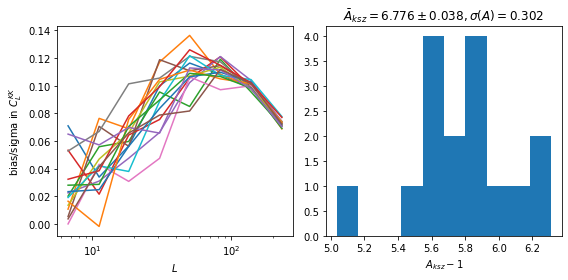

In [22]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, figsize=(8,4))

d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_hilc_hilc_hilc_hilc/output_rot%d"
plot_e2e_sims(axs, d,            
              opj(d%0,"mean_field_nsim64"),
              opj(d%0,"rdn0_outputs_nsim32.pkl"), 
              binner, est="qe", nsim=64)
fig.tight_layout()
fig.savefig("e2e_lmax6000_actonly.png",dpi=300)

## No noise, with lensing

isim: 0
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.794101 +/- 4.574736
binned A_ksz = 8.165587 +/- 4.739100
isim: 1
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.199114 +/- 4.574736
binned A_ksz = 8.548123 +/- 4.739100
isim: 2
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.497086 +/- 4.574736
binned A_ksz = 7.830135 +/- 4.739100
isim: 3
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.747007 +/- 4.574736
binned A_ksz = 8.081724 +/- 4.739100
isim: 4
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.528550 +/- 4.574736
binned A_ksz = 7.869320 +/- 4.739100
isim: 5
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.009558 +/- 4.574736
binned A_ksz = 8.310759 +/- 4.739100
isim: 6
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.885662 +/- 4.574736
binned A_ksz = 7.206541 +/- 4.739100
isim: 7
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.315276 +/- 4.574736
binned A_ksz = 8.730102 +/- 4.739100
isim: 8
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.821346 +/- 4.574736
binned A_ksz = 8.133518 +/- 4.739100
isim: 9
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.740565 +/- 4.574736
binned A_ksz = 8.108288 +/- 4.739100
isim: 10
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.592334 +/- 4.574736
binned A_ksz = 7.896950 +/- 4.739100
isim: 11
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.760144 +/- 4.574736
binned A_ksz = 8.093622 +/- 4.739100
isim: 12
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.496187 +/- 4.574736
binned A_ksz = 7.915312 +/- 4.739100
isim: 13
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.158570 +/- 4.574736
binned A_ksz = 8.569117 +/- 4.739100
isim: 14
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.695779 +/- 4.574736
binned A_ksz = 8.044911 +/- 4.739100
isim: 15
est: qe
32


/tmp/ipykernel_1760310/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_1760310/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.357210 +/- 4.574736
binned A_ksz = 7.638008 +/- 4.739100


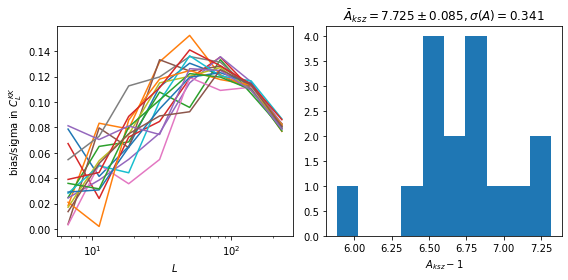

In [10]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, figsize=(8,4))


d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_noiseless_hilc_hilc_hilc_hilc/output_rot%d"
plot_e2e_sims(axs, d,            
              opj(d%0,"mean_field_nsim64"),
              opj(d%0,"rdn0_outputs_nsim32.pkl"), 
              binner, est="qe", nsim=16)
fig.tight_layout()
fig.savefig("e2e_lmax5000_nonoise.png",dpi=300)

isim: 0
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.524873 +/- 6.623958
binned A_ksz = 1.851720 +/- 6.867075
isim: 1
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.143225 +/- 6.623958
binned A_ksz = 2.638958 +/- 6.867075
isim: 2
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.631097 +/- 6.623958
binned A_ksz = 2.012246 +/- 6.867075
isim: 3
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.841913 +/- 6.623958
binned A_ksz = 2.226596 +/- 6.867075
isim: 4
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.849459 +/- 6.623958
binned A_ksz = 2.282136 +/- 6.867075
isim: 5
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.783222 +/- 6.623958
binned A_ksz = 2.155366 +/- 6.867075
isim: 6
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.674279 +/- 6.623958
binned A_ksz = 2.112149 +/- 6.867075
isim: 7
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.801589 +/- 6.623958
binned A_ksz = 2.143521 +/- 6.867075
isim: 8
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.820826 +/- 6.623958
binned A_ksz = 2.230310 +/- 6.867075
isim: 9
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.479205 +/- 6.623958
binned A_ksz = 1.860808 +/- 6.867075
isim: 10
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.798969 +/- 6.623958
binned A_ksz = 2.175806 +/- 6.867075
isim: 11
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.450992 +/- 6.623958
binned A_ksz = 1.817783 +/- 6.867075
isim: 12
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.841365 +/- 6.623958
binned A_ksz = 2.221277 +/- 6.867075
isim: 13
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.917867 +/- 6.623958
binned A_ksz = 2.355424 +/- 6.867075
isim: 14
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.784498 +/- 6.623958
binned A_ksz = 2.092170 +/- 6.867075
isim: 15
est: lh
32


/tmp/ipykernel_743178/1344597632.py:138: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_743178/1344597632.py:140: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.571438 +/- 6.623958
binned A_ksz = 1.963878 +/- 6.867075


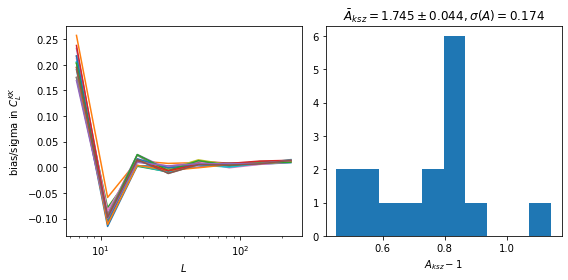

In [36]:
%matplotlib inline
fig,axs=plt.subplots(ncols=2, figsize=(8,4))


d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax6000_noiseless_lh_hilc_hilc_hilc_hilc/output_rot%d"
plot_e2e_sims(axs, d,            
              opj(d%0,"mean_field_nsim64_lh"),
              opj(d%0,"rdn0_outputs_lh_nsim32.pkl"), 
              binner, est="lh", nsim=16)
fig.tight_layout()
fig.savefig("e2e_lmax5000_nonoise.png",dpi=300)

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

plot_rdn0=True
plot_mcn0=True
plot_meanfield=True
plot_meanfield_correction=True
plot_theory=True
divide_by_uL2=False

yscale="log"
d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_noiseless_hilc_hilc_hilc_hilc/output_rot0"
plot_clKK(ax, d, 
           binner, mask_60sk_file, color='C0', rdn0_file=opj(d,"rdn0_outputs_nsim32.pkl"),
           label="hILC, lmax=5000",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir=opj(d,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL2=divide_by_uL2,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction) #, u_L=u_L)   

d = "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_hilc_hilc_hilc_hilc/output_rot0"
plot_clKK(ax, d, 
           binner, mask_60sk_file, color='C1', rdn0_file=opj(d,"rdn0_outputs_nsim32.pkl"),
           label="hILC, lmax=5000",  
           yscale=yscale,  lpower=lpower,
           meanfield_dir=opj(d,"mean_field_nsim64"), plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
           offsets = offsets[0], est="qe", divide_by_uL2=divide_by_uL2,
           add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
           plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
           plot_meanfield_correction=plot_meanfield_correction) #, u_L=u_L)   

if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")
    
#ax.plot(binner.bin_mids, mcn0_err, 'k--')
    
lg=ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

In [74]:
%matplotlib inline

fig,axs=plt.subplots(ncols=2, figsize=(8,4))
ax, ax_hist=axs

est = "qe"

if est=="lh":
    output_path_template="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_lh_hilc_hilc_hilc_hilc/output_rot%d"
    meanfield_dir=output_path_template%0 + "/mean_field_nsim64_lh"
    rdn0_file=output_path_template%0 + "/rdn0_outputs_lh_nsim32.pkl"
    filename = "e2e_amp_lmax5000_lh.png"
elif est=="psh":
    output_path_template="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_psh_hilc_hilc_hilc_hilc/output_rot%d"
    meanfield_dir=output_path_template%0 + "/mean_field_nsim64_psh"
    rdn0_file=output_path_template%0 + "/rdn0_outputs_psh_nsim32.pkl"  
    filename = "e2e_amp_lmax5000_psh.png"
elif est=="qe":
    output_path_template="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_actonly_hilc_hilc_hilc_hilc/output_rot%d"
    meanfield_dir=output_path_template%0 + "/mean_field_nsim64"
    rdn0_file=output_path_template%0 + "/rdn0_outputs_nsim32.pkl"
    filename = "e2e_amp_lmax5000_qe.png"
else:
    raise ValueError("don't recognize est %s"%est)
mask_file="/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_60.00sk.fits"
mask=enmap.read_map(mask_file)
w4 = maps.wfactor(4,mask)



[  5  35  65  94 124 153 183 213 242 272 301]
isim: 0
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.447030 +/- 3.432918
binned A_ksz = -2.955309 +/- 3.549639
isim: 1
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.915835 +/- 3.425093
binned A_ksz = 9.049224 +/- 3.541450
isim: 2
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.574385 +/- 3.428311
binned A_ksz = 21.958180 +/- 3.544742
isim: 3
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.676108 +/- 3.429260
binned A_ksz = 28.961148 +/- 3.545645
isim: 4
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 20.887590 +/- 3.424981
binned A_ksz = 22.618226 +/- 3.541243
isim: 5
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.329768 +/- 3.436602
binned A_ksz = -0.658054 +/- 3.553458
isim: 6
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.727109 +/- 3.433426
binned A_ksz = 33.431869 +/- 3.549943
isim: 7
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.136051 +/- 3.430670
binned A_ksz = 15.442197 +/- 3.547176
isim: 8
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 24.870091 +/- 3.427110
binned A_ksz = 28.832691 +/- 3.543517
isim: 9
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.075664 +/- 3.428803
binned A_ksz = 7.032885 +/- 3.545171
isim: 10
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.770972 +/- 3.430030
binned A_ksz = 2.520378 +/- 3.546631
isim: 11
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.074054 +/- 3.424903
binned A_ksz = 0.026287 +/- 3.541374
isim: 12
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.446043 +/- 3.427356
binned A_ksz = 0.766520 +/- 3.543736
isim: 13
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 15.547180 +/- 3.426134
binned A_ksz = 14.607619 +/- 3.542406
isim: 14
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.553401 +/- 3.425141
binned A_ksz = 6.817286 +/- 3.541432
isim: 15
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.407581 +/- 3.425343
binned A_ksz = 9.953585 +/- 3.541729
isim: 16
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.059265 +/- 3.427072
binned A_ksz = 0.711359 +/- 3.543572
isim: 17
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.120847 +/- 3.426318
binned A_ksz = 6.770306 +/- 3.542500
isim: 18
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.161903 +/- 3.437713
binned A_ksz = 20.773320 +/- 3.554569
isim: 19
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.541949 +/- 3.422304
binned A_ksz = 5.485637 +/- 3.538626
isim: 20
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 7.243462 +/- 3.428862
binned A_ksz = 7.676610 +/- 3.545348
isim: 21
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 26.572898 +/- 3.424406
binned A_ksz = 27.744960 +/- 3.540726
isim: 22
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.567682 +/- 3.430743
binned A_ksz = -2.949026 +/- 3.547398
isim: 23
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.630735 +/- 3.436206
binned A_ksz = 0.352088 +/- 3.552990
isim: 24
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 4.816744 +/- 3.433733
binned A_ksz = 5.888506 +/- 3.550316
isim: 25
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.672998 +/- 3.434633
binned A_ksz = 9.050484 +/- 3.551383
isim: 26
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 8.548721 +/- 3.430349
binned A_ksz = 9.032064 +/- 3.546884
isim: 27
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.223435 +/- 3.428801
binned A_ksz = 15.021060 +/- 3.545214
isim: 28
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -2.942426 +/- 3.425785
binned A_ksz = 0.604400 +/- 3.542125
isim: 29
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.160304 +/- 3.417437
binned A_ksz = 6.580171 +/- 3.533443
isim: 30
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.681791 +/- 3.431663
binned A_ksz = 6.666219 +/- 3.548097
isim: 31
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 32.770495 +/- 3.422672
binned A_ksz = 37.673737 +/- 3.538825
isim: 32
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.401095 +/- 3.430529
binned A_ksz = 10.991238 +/- 3.547050
isim: 33
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 15.202259 +/- 3.419020
binned A_ksz = 17.714862 +/- 3.535100
isim: 34
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 28.712547 +/- 3.440267
binned A_ksz = 27.570228 +/- 3.557203
isim: 35
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -4.567965 +/- 3.427647
binned A_ksz = -6.344435 +/- 3.544176
isim: 36
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 36.714713 +/- 3.422669
binned A_ksz = 34.356919 +/- 3.538967
isim: 37
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 11.066065 +/- 3.437061
binned A_ksz = 13.881080 +/- 3.553863
isim: 38
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 13.072897 +/- 3.432170
binned A_ksz = 10.513944 +/- 3.548752
isim: 39
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.753783 +/- 3.437609
binned A_ksz = 17.503436 +/- 3.554517
isim: 40
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 24.372659 +/- 3.405873
binned A_ksz = 27.112984 +/- 3.521357
isim: 41
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -1.251970 +/- 3.430518
binned A_ksz = 0.119601 +/- 3.547148
isim: 42
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -9.793455 +/- 3.430190
binned A_ksz = -11.944154 +/- 3.546727
isim: 43
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 0.728934 +/- 3.422648
binned A_ksz = 0.760196 +/- 3.538996
isim: 44
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 40.388164 +/- 3.439019
binned A_ksz = 40.922512 +/- 3.555939
isim: 45
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 2.589509 +/- 3.419007
binned A_ksz = 1.669201 +/- 3.535078
isim: 46
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.023461 +/- 3.421687
binned A_ksz = 29.676239 +/- 3.537864
isim: 47
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.483556 +/- 3.425788
binned A_ksz = 9.846959 +/- 3.542111
isim: 48
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.819632 +/- 3.431985
binned A_ksz = 22.684283 +/- 3.548643
isim: 49
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 18.788617 +/- 3.431816
binned A_ksz = 18.492294 +/- 3.548459
isim: 50
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 32.038760 +/- 3.426409
binned A_ksz = 29.876232 +/- 3.542809
isim: 51
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 14.143466 +/- 3.435846
binned A_ksz = 16.338996 +/- 3.552577
isim: 52
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.782948 +/- 3.437160
binned A_ksz = 1.337252 +/- 3.553933
isim: 53
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 19.937169 +/- 3.418781
binned A_ksz = 22.676099 +/- 3.534911
isim: 54
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 29.386905 +/- 3.427836
binned A_ksz = 29.768987 +/- 3.544355
isim: 55
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -3.004434 +/- 3.432709
binned A_ksz = -5.552893 +/- 3.549427
isim: 56
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 12.601207 +/- 3.435357
binned A_ksz = 12.520489 +/- 3.552148
isim: 57
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 1.196339 +/- 3.425094
binned A_ksz = -0.633828 +/- 3.541455
isim: 58
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = -5.314142 +/- 3.435157
binned A_ksz = -4.777520 +/- 3.551933
isim: 59
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 9.420916 +/- 3.427304
binned A_ksz = 9.838922 +/- 3.543749
isim: 60
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.360406 +/- 3.430307
binned A_ksz = 7.833201 +/- 3.546849
isim: 61
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 30.065556 +/- 3.422479
binned A_ksz = 29.896657 +/- 3.538622
isim: 62
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 17.498303 +/- 3.424398
binned A_ksz = 15.484939 +/- 3.540734
isim: 63
est: qe
32


/tmp/ipykernel_2299769/1413192794.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
/tmp/ipykernel_2299769/1413192794.py:124: RuntimeWarning: invalid value encountered in true_divide
  outputs["frac_diff"] = (CL_KK/clKK_ksz-1)


A_ksz = 6.072175 +/- 3.442943
binned A_ksz = 1.750713 +/- 3.559959


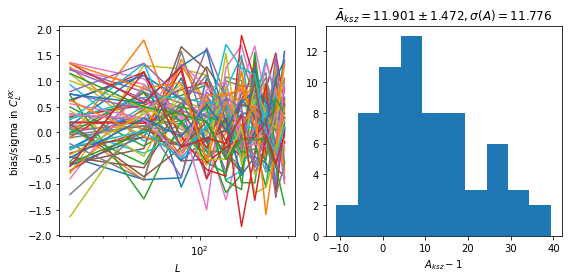

In [74]:
lmin=5
binner=ClBinner(lmin=lmin, lmax=300, nbin=10, log=False)
print(binner.bin_lims)
    
nsim=64
#frac_diffs = np.zeros((nsim,binner.nbin))
#bias_over_sigs = np.zeros_like(frac_diffs)
frac_diffs=[]
bias_over_sigs=[]
amps = []

nsim_read=0
for irot in range(nsim):
    print("isim:",irot)
    d=output_path_template%irot
    try:
        with open(opj(d, "auto_outputs.pkl"), "rb") as f:
            pickle.load(f)
    except Exception as e:
        print(e)
        print("skipping irot=%d"%irot)
        continue
    nsim_read+=1

    cl_kk_stuff = get_CLKK_stuff(
            d, meanfield_dir, rdn0_file, w1, w4, binner, use_mcn0=True,
            est=est
    )
    bias_over_sigs.append( cl_kk_stuff["bias_over_sig"] )
    frac_diffs.append( cl_kk_stuff["frac_diff"] )
    
    #ax.plot(binner.bin_mids, CL_KK / binner(auto_outputs["Cl_KK_ksz_theory"])-1)
    ax.plot(binner.bin_mids, binner(cl_kk_stuff["bias_over_sig"]))

    amps.append(cl_kk_stuff["A_ksz"])
    
    print("A_ksz = %.6f +/- %.6f"%(cl_kk_stuff["A_ksz"], cl_kk_stuff["A_ksz_err"]))
    print("binned A_ksz = %.6f +/- %.6f"%(cl_kk_stuff["A_ksz_binned"], cl_kk_stuff["A_ksz_binned_err"]))
    

#ax.plot(binner.bin_mids, binner.bin_mids**2*binner(auto_outputs["Cl_KK_ksz_theory"]), color="k")
frac_diffs = np.array(frac_diffs)
bias_over_sigs = np.array(bias_over_sigs)
    
mean_frac_diff = frac_diffs.mean(axis=0)
mean_frac_diff_err = np.std(frac_diffs, axis=0)/np.sqrt(nsim_read-1)

#ax.fill_between(binner.bin_mids, mean_frac_diff-mean_frac_diff_err, mean_frac_diff+mean_frac_diff_err, 
#               color="k", alpha=0.25)

ax_hist.hist(np.array(amps)-1)
ax_hist.set_xlabel("$A_{ksz} - 1$")
A_mean, A_err = np.mean(amps), np.std(amps)/np.sqrt(nsim)
ax_hist.set_title(r"$\bar{A}_{ksz} = %.3f \pm %.3f, \sigma(A)=%.3f$"%(A_mean, A_err, np.std(amps)))

#ax.set_yscale('symlog', linthreshy=10.)
ax.set_xscale('log')
ax.set_xlabel("$L$")
ax.set_ylabel("bias/sigma in $C_L^{KK}$")

fig.tight_layout()
fig.savefig(filename, dpi=300) #, bbox_extra_artists=(lg,))

##################
/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_lh_hilc_hilc_hilc_hilc/output_rot0


KeyboardInterrupt: 

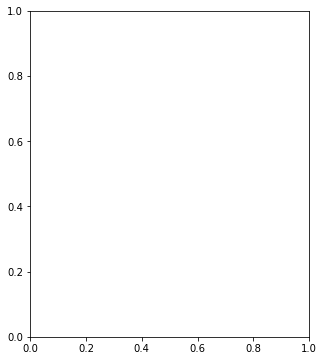

In [19]:
#Something is up...check mean-field and rdn0?
%matplotlib inline

binner = ClBinner(lmin=5, lmax=300, nbin=20, log=False)

fig,ax=plt.subplots(figsize=(5,6))
#fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
#lpower=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="symlog"
linthreshy=0.1
offsets=np.linspace(-0.05,0.05,6)
plot_rdn0=True
plot_meanfield_correction=True
lpower=2
plot_raw_auto=True
plot_mcn0=True
do_one_leg_cleaned=False

plot_clKK(ax, "/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_auto_config_lmax5000_lh_hilc_hilc_hilc_hilc/output_rot0", 
                   binner, color='C3', rdn0_file="rdn0_outputs_lh_nsim32.pkl",
          mask_file=mask_file,
          label="90 GHz, v4 alms, lmax=4000, Gaussian sims",  
           yscale=yscale,  lpower=lpower, lh=True,
          meanfield_dir="mean_field_nsim64_lh", plot_rdn0=plot_rdn0, plot_mcn0=plot_mcn0,
          offsets = offsets[3],
         add_to_err=0., #binner(fg_terms_iici["trispectrum_qe"]), 
         plot_meanfield=plot_meanfield, plot_raw_auto=plot_raw_auto,
                  plot_meanfield_correction=plot_meanfield_correction, raw_auto=False) #, u_L=u_L)


if plot_meanfield:
    ax.plot([],[],":",color="k", label="meanfield auto")
if plot_rdn0:
    ax.plot([],[],"--", color="k", label="RDN0")
if plot_meanfield_correction:
    ax.plot([],[],linestyle=(0, (3, 1, 1, 1)), color='k', label="meanfield correction")
if plot_mcn0:
    ax.plot([],[],linestyle="-.", color='k', label="MCN0")
if plot_raw_auto:
    ax.errorbar([],[],yerr=[],fmt='o',color='k',mfc='none',label="raw auto")

ax.legend()
ax.set_xscale('log')

In [8]:
alm=hp.read_alm("/home/r/rbond/jiaqu/scratch/DR6/maps/sims/ksz_4pt/coadd_data/kcoadd_f_090_lmax7000_v4_70mask_v3_split0.fits")
cl=curvedsky.alm2cl(alm)

FileNotFoundError: [Errno 2] No such file or directory: '/home/r/rbond/jiaqu/scratch/DR6/maps/sims/ksz_4pt/coadd_data/kcoadd_f_090_lmax7000_v4_70mask_v3_split0.fits'

In [10]:
%matplotlib inline

ksz_alm_0 = hp.read_alm("/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/hilc_lmax7000/sim_planck200_act00_00001/ksz_rot0_maskedetc.fits")
ksz_alm_1 = hp.read_alm("/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/hilc_lmax7000/sim_planck201_act00_00002/ksz_rot1_maskedetc.fits")

cl_00 = curvedsky.alm2cl(ksz_alm_0)
cl_11 = curvedsky.alm2cl(ksz_alm_1)
cl_01 = curvedsky.alm2cl(ksz_alm_0,ksz_alm_1)

In [11]:
ksz_alm_orig = hp.read_alm("../tests/alms_4e3_2048_50_50_ksz.fits")
cl_orig = curvedsky.alm2cl(ksz_alm_orig)

In [ ]:


ksz_alm_rot = curvedsky.rotate_alm(
            ksz_alm_orig, rot_angle[0], rot_angle[1], rot_angle[2],
            method="ducc0")

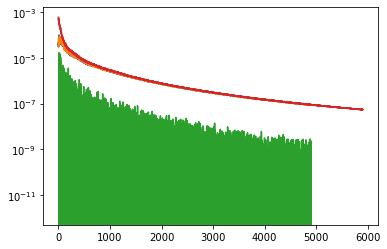

In [12]:
fig,ax=plt.subplots()
ax.plot(cl_00[100:])
ax.plot(cl_11[100:])
ax.plot(cl_01[100:])
ax.plot(cl_orig[100:]*0.23)
ax.set_yscale('log')

irot: 0
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -1.25 +/- 1.13
irot: 1
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.25 +/- 1.13
irot: 2
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 5.78 +/- 1.13
irot: 3
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.68 +/- 1.13
irot: 4
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.16 +/- 1.13
irot: 5
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.64 +/- 1.13
irot: 6
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.24 +/- 1.13
irot: 7
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.30 +/- 1.13
irot: 8
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.41 +/- 1.13
irot: 9
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.89 +/- 1.13
irot: 10
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.41 +/- 1.13
irot: 11
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.29 +/- 1.13
irot: 12
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 6.19 +/- 1.13
irot: 13
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.30 +/- 1.13
irot: 14
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -2.32 +/- 1.13
irot: 15
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.38 +/- 1.13
irot: 16
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.69 +/- 1.13
irot: 17
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.65 +/- 1.13
irot: 18
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -2.35 +/- 1.13
irot: 19
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.19 +/- 1.13
irot: 20
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.49 +/- 1.13
irot: 21
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.20 +/- 1.13
irot: 22
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.44 +/- 1.13
irot: 23
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.09 +/- 1.13
irot: 24
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.42 +/- 1.13
irot: 25
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 5.75 +/- 1.13
irot: 26
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.06 +/- 1.13
irot: 27
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.68 +/- 1.13
irot: 28
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -3.35 +/- 1.13
irot: 29
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.15 +/- 1.12
irot: 30
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.93 +/- 1.13
irot: 31
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.52 +/- 1.12
irot: 32
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.34 +/- 1.13
irot: 33
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.52 +/- 1.13
irot: 34
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -1.43 +/- 1.13
irot: 35
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.20 +/- 1.13
irot: 36
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 5.09 +/- 1.13
irot: 37
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.65 +/- 1.13
irot: 38
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.38 +/- 1.13
irot: 39
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.21 +/- 1.13
irot: 40
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.33 +/- 1.12
irot: 41
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.05 +/- 1.13
irot: 42
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.53 +/- 1.13
irot: 43
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.99 +/- 1.13
irot: 44
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.85 +/- 1.13
irot: 45
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.05 +/- 1.13
irot: 46
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.40 +/- 1.13
irot: 47
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.13 +/- 1.13
irot: 48
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 7.23 +/- 1.13
irot: 49
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.54 +/- 1.13
irot: 50
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.68 +/- 1.13
irot: 51
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.09 +/- 1.13
irot: 52
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.45 +/- 1.13
irot: 53
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.36 +/- 1.13
irot: 54
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.62 +/- 1.13
irot: 55
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 6.29 +/- 1.13
irot: 56
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.79 +/- 1.13
irot: 57
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -2.18 +/- 1.13
irot: 58
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.46 +/- 1.13
irot: 59
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.71 +/- 1.13
irot: 60
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -0.28 +/- 1.13
irot: 61
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 7.33 +/- 1.12
irot: 62
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.85 +/- 1.13
irot: 63
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.72 +/- 1.13
irot: 64
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 6.20 +/- 1.12
irot: 65
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.30 +/- 1.13
irot: 66
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 2.74 +/- 1.13
irot: 67
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -1.30 +/- 1.13
irot: 68
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.89 +/- 1.13
irot: 69
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 4.28 +/- 1.12
irot: 70
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -3.23 +/- 1.13
irot: 71
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 6.54 +/- 1.13
irot: 72
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.87 +/- 1.13
irot: 73
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = -1.80 +/- 1.13
irot: 74
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 6.88 +/- 1.13
irot: 75
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 3.14 +/- 1.13
irot: 76
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 1.13 +/- 1.13
irot: 77
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 0.13 +/- 1.12
irot: 78
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


A_ksz = 5.11 +/- 1.13
irot: 79
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'lmin', 'lmax', 'profile'])
32
A_ksz = 0.01 +/- 1.13


/tmp/ipykernel_1333139/2270158808.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]


Text(0, 0.5, 'bias/sigma in $C_L^{KK}$')

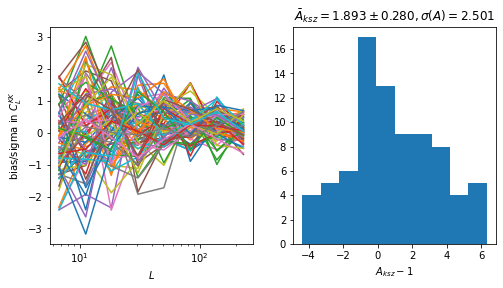

In [7]:
%matplotlib inline

fig,axs=plt.subplots(ncols=2, figsize=(8,4))
ax, ax_hist=axs

output_path_template="/pscratch/sd/m/maccrann/ksz_outputs/sim_e2e_test/output_run_auto_config_hilc_hilc_hilc_hilc_lmax4000_rot%d"

meanfield_dir=output_path_template%0 + "/mean_field_nsim64"
rdn0_file=output_path_template%0 + "/rdn0_outputs_nsim32.pkl"
mask_file="/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_60.00sk.fits"
mask=enmap.read_map(mask_file)
w4 = maps.wfactor(4,mask)


with open(opj(meanfield_dir,"Ks_ab_mean.pkl"), "rb") as f:
    Ks_ab_mean=pickle.load(f)
with open(opj(meanfield_dir,"Ks_cd_mean.pkl"), "rb") as f:
    Ks_cd_mean=pickle.load(f)
fsky=0.3
lmin=10
    
nsim=80
#frac_diffs = np.zeros((nsim,binner.nbin))
#bias_over_sigs = np.zeros_like(frac_diffs)
frac_diffs=[]
bias_over_sigs=[]
amps = []

nsim_read=0
for irot in range(nsim):
    print("irot: %d"%irot)
    d=output_path_template%irot
    try:
        with open(opj(d, "auto_outputs.pkl"), "rb") as f:
            auto_outputs = pickle.load(f)
    except Exception as e:
        print(e)
        print("skipping irot=%d"%irot)
        continue
    nsim_read+=1
    print(auto_outputs.keys())
    theory_N0_wnoise = auto_outputs["N0"]
    Ls = np.arange(binner.lmax+1)
    clKK_ksz = auto_outputs["Cl_KK_ksz_theory"]
    clKK2 = (theory_N0_wnoise[:binner.lmax+1] + 
             clKK_ksz[:binner.lmax+1])**2
    var_CLKK = 2/(2*Ls+1)/fsky * clKK2
    
    #ax.plot(binner(auto_outputs["cl_KK_raw"]), label="rot %d"%irot)
    #use mcn0 for now as we only ran rdn0 for first sim
    CL_KK_not_binned, CL_KK, CL_KK_raw, CL_KK_mfcorrected, rdn0, mcn0, mcn0_err, mf_auto = get_CLKK(d, meanfield_dir, rdn0_file, w4, binner, use_mcn0=True)
    
    
    bias_over_sig = (CL_KK_not_binned-clKK_ksz)[:binner.lmax+1]/np.sqrt(var_CLKK)[:binner.lmax+1]
    bias_over_sigs.append( binner(bias_over_sig) )
    
    frac_diffs.append( (CL_KK/binner(auto_outputs["Cl_KK_ksz_theory"])-1) )
    
    #ax.plot(binner.bin_mids, CL_KK / binner(auto_outputs["Cl_KK_ksz_theory"])-1)
    ax.plot(binner.bin_mids, binner(bias_over_sig))
    
    denom = np.sum( (clKK_ksz*clKK_ksz)[lmin:binner.lmax+1]/var_CLKK[lmin:binner.lmax+1] )
    num = np.sum( (CL_KK_not_binned * clKK_ksz)[lmin:binner.lmax+1] / var_CLKK[lmin:binner.lmax+1] )
    amp = num/denom
    amps.append(amp)
    amp_err = np.sqrt(1./denom)
    print("A_ksz = %.2f +/- %.2f"%(amp, amp_err))
    

#ax.plot(binner.bin_mids, binner.bin_mids**2*binner(auto_outputs["Cl_KK_ksz_theory"]), color="k")
frac_diffs = np.array(frac_diffs)
bias_over_sigs = np.array(bias_over_sigs)
    
mean_frac_diff = frac_diffs.mean(axis=0)
mean_frac_diff_err = np.std(frac_diffs, axis=0)/np.sqrt(nsim_read-1)

#ax.fill_between(binner.bin_mids, mean_frac_diff-mean_frac_diff_err, mean_frac_diff+mean_frac_diff_err, 
#               color="k", alpha=0.25)

ax_hist.hist(np.array(amps)-1)
ax_hist.set_xlabel("$A_{ksz} - 1$")
A_mean, A_err = np.mean(amps), np.std(amps)/np.sqrt(nsim)
ax_hist.set_title(r"$\bar{A}_{ksz} = %.3f \pm %.3f, \sigma(A)=%.3f$"%(A_mean, A_err, np.std(amps)))

#ax.set_yscale('symlog', linthreshy=10.)
ax.set_xscale('log')
ax.set_xlabel("$L$")
ax.set_ylabel("bias/sigma in $C_L^{KK}$")

/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000_kszonly_datafilters/output_hilc_hilc_hilc_hilc_run_auto_config_rot0
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'cl_rksz', 'cltot_A', 'cltot_B', 'cltot_C', 'cltot_D', 'cltot_AC', 'cltot_BD', 'cltot_AD', 'cltot_BC', 'total_filter_A', 'total_filter_B', 'total_filter_C', 'total_filter_D', 'lmin', 'lmax', 'profile'])
32
[5.47981607e-12 5.35523410e-12 5.01599987e-12 5.15006390e-12
 5.16146029e-12 5.27151770e-12 5.47885615e-12 5.84779088e-12]
[3.08257524e-13 2.56232037e-13 1.36489289e-13 8.29043106e-14
 4.99833123e-14 3.37174472e-14 2.20109279e-14 1.23628014e-14]
A_ksz = 0.0171 +/- 1.1762
/pscratch/sd/m/maccrann/cmb/act_

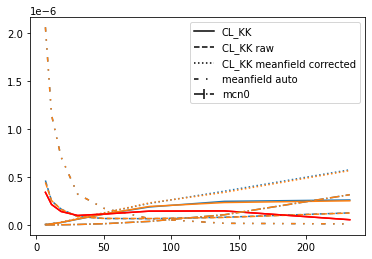

In [12]:
%matplotlib inline
# ksz only sims

fig,ax=plt.subplots()

sim_dir="/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000_kszonly_datafilters/output_hilc_hilc_hilc_hilc_run_auto_config_rot%d"
meanfield_dir=(sim_dir%0)+"/mean_field_nsim32"
rdn0_file=(sim_dir%0)+"/rdn0_outputs_nsim32.pkl"
mask_file="/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_60.00sk.fits"
mask=enmap.read_map(mask_file)
w4 = maps.wfactor(4,mask)
#with open(opj(meanfield_dir,"Ks_ab_mean.pkl"), "rb") as f:
##    Ks_ab_mean=pickle.load(f)
#with open(opj(meanfield_dir,"Ks_cd_mean.pkl"), "rb") as f:
#    Ks_cd_mean=pickle.load(f)
fsky=0.3
lmin=5

lfac=2
    
for irot in range(5):
    d=sim_dir%irot
    print(d)
    with open(opj(d, "auto_outputs.pkl"), "rb") as f:
        auto_outputs = pickle.load(f)
    print(auto_outputs.keys())
    theory_N0_wnoise = auto_outputs["N0"]
    Ls = np.arange(binner.lmax+1)
    clKK_ksz = auto_outputs["Cl_KK_ksz_theory"]
    clKK2 = (theory_N0_wnoise[:binner.lmax+1] + 
             clKK_ksz[:binner.lmax+1])**2
    var_CLKK = 2/(2*Ls+1)/fsky * clKK2
    
    #ax.plot(binner(auto_outputs["cl_KK_raw"]), label="rot %d"%irot)
    #use mcn0 for now as we only ran rdn0 for first sim
    CL_KK_not_binned, CL_KK, CL_KK_raw, CL_KK_mfcorrected, rdn0, mcn0, mcn0_err, mf_auto = get_CLKK(d, meanfield_dir, rdn0_file, w4, binner, use_mcn0=True)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK, '-', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK_raw, '--', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK_mfcorrected, ':', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*mf_auto, linestyle=(0, (3, 5, 1, 5, 1, 5)), color="C%d"%irot)
    ax.errorbar(binner.bin_mids, binner.bin_mids**lfac*mcn0, yerr=binner.bin_mids**lfac*mcn0_err,  linestyle='-.', color="C%d"%irot)
    print(mcn0)
    print(mcn0_err)
    
    denom = np.sum( (clKK_ksz*clKK_ksz)[lmin:binner.lmax+1]/var_CLKK[lmin:binner.lmax+1] )
    num = np.sum( (CL_KK_not_binned * clKK_ksz)[lmin:binner.lmax+1] / var_CLKK[lmin:binner.lmax+1] )
    amp = num/denom
    amp_err = np.sqrt(1./denom)
    print("A_ksz = %.4f +/- %.4f"%(amp, amp_err))

    ax.plot(binner.bin_mids, binner.bin_mids**lfac*binner(auto_outputs["Cl_KK_ksz_theory"]), color="red")

ax.plot([],[], '-', color="k", label="CL_KK")
ax.plot([],[], '--', color="k", label="CL_KK raw")
ax.plot([],[], ':', color="k", label="CL_KK meanfield corrected")
ax.errorbar([],[],yerr=[], linestyle='-.', color="k", label="mcn0")
ax.plot([],[], linestyle=(0, (3, 5, 1, 5, 1, 5)), color="k", label="meanfield auto")
    
ax.legend()

#ax.set_yscale('symlog', linthreshy=1.e-7)

1.0000000000000235
/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000_kszonly_datafilters_fullsky/output_hilc_hilc_hilc_hilc_run_auto_config_rot0
dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'cl_rksz', 'cltot_A', 'cltot_B', 'cltot_C', 'cltot_D', 'cltot_AC', 'cltot_BD', 'cltot_AD', 'cltot_BC', 'total_filter_A', 'total_filter_B', 'total_filter_C', 'total_filter_D', 'lmin', 'lmax', 'profile'])
32
[5.38474068e-12 5.49883624e-12 5.39993758e-12 5.43725119e-12
 5.47695286e-12 5.59299940e-12 5.77749957e-12 6.16066016e-12]
[1.90626876e-13 1.45442159e-13 6.15875093e-14 3.40486729e-14
 3.02076569e-14 1.50294543e-14 1.21288385e-14 6.71869918e-15]
A_ksz = 1.02 +/- 12.90


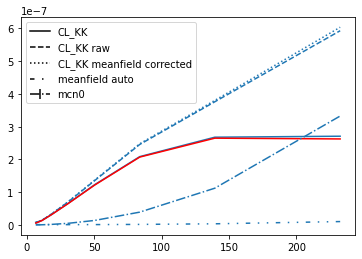

In [7]:
%matplotlib inline
# ksz only sims

fig,ax=plt.subplots()

sim_dir="/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000_kszonly_datafilters_fullsky/output_hilc_hilc_hilc_hilc_run_auto_config_rot%d"
meanfield_dir=(sim_dir%0)+"/mean_field_nsim32"
rdn0_file=(sim_dir%0)+"/rdn0_outputs_nsim32.pkl"
mask_file="/global/cfs/projectdirs/act/data/maccrann/fullsky_mask.fits"
mask=enmap.read_map(mask_file)
w4 = maps.wfactor(4,mask)

print(w4)
#with open(opj(meanfield_dir,"Ks_ab_mean.pkl"), "rb") as f:
##    Ks_ab_mean=pickle.load(f)
#with open(opj(meanfield_dir,"Ks_cd_mean.pkl"), "rb") as f:
#    Ks_cd_mean=pickle.load(f)
fsky=0.3
lmin=5

lfac=2
    
for irot in range(1):
    d=sim_dir%irot
    print(d)
    with open(opj(d, "auto_outputs.pkl"), "rb") as f:
        auto_outputs = pickle.load(f)
    print(auto_outputs.keys())
    theory_N0_wnoise = auto_outputs["N0"]
    Ls = np.arange(binner.lmax+1)
    clKK_ksz = auto_outputs["Cl_KK_ksz_theory"]
    clKK2 = (theory_N0_wnoise[:binner.lmax+1] + 
             clKK_ksz[:binner.lmax+1])**2
    var_CLKK = 2/(2*Ls+1)/fsky * clKK2
    
    #ax.plot(binner(auto_outputs["cl_KK_raw"]), label="rot %d"%irot)
    #use mcn0 for now as we only ran rdn0 for first sim
    CL_KK_not_binned, CL_KK, CL_KK_raw, CL_KK_mfcorrected, rdn0, mcn0, mcn0_err, mf_auto = get_CLKK(d, meanfield_dir, rdn0_file, w4, binner, use_mcn0=True)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK, '-', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK_raw, '--', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*CL_KK_mfcorrected, ':', color="C%d"%irot)
    ax.plot(binner.bin_mids, binner.bin_mids**lfac*mf_auto, linestyle=(0, (3, 5, 1, 5, 1, 5)), color="C%d"%irot)
    ax.errorbar(binner.bin_mids, binner.bin_mids**lfac*mcn0, yerr=binner.bin_mids**lfac*mcn0_err,  linestyle='-.', color="C%d"%irot)
    print(mcn0)
    print(mcn0_err)
    
    denom = np.sum( (clKK_ksz*clKK_ksz)[lmin:binner.lmax+1]/var_CLKK[lmin:binner.lmax+1] )
    num = np.sum( (CL_KK_not_binned * clKK_ksz)[lmin:binner.lmax+1] / var_CLKK[lmin:binner.lmax+1] )
    amp = num/denom
    amp_err = np.sqrt(1./denom)
    print("A_ksz = %.2f +/- %.2f"%(amp, amp_err))

    ax.plot(binner.bin_mids, binner.bin_mids**lfac*binner(auto_outputs["Cl_KK_ksz_theory"]), color="red")

ax.plot([],[], '-', color="k", label="CL_KK")
ax.plot([],[], '--', color="k", label="CL_KK raw")
ax.plot([],[], ':', color="k", label="CL_KK meanfield corrected")
ax.errorbar([],[],yerr=[], linestyle='-.', color="k", label="mcn0")
ax.plot([],[], linestyle=(0, (3, 5, 1, 5, 1, 5)), color="k", label="meanfield auto")
    
ax.legend()

#ax.set_yscale('symlog', linthreshy=1.e-7)

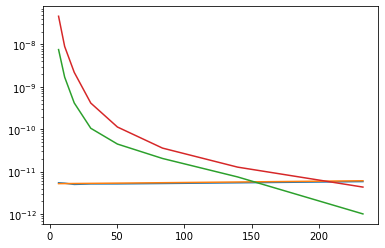

In [22]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(binner.bin_mids, mcn0)
ax.plot(binner.bin_mids, binner(auto_outputs["N0_ksz_theory"]))
ax.plot(binner.bin_mids, binner(auto_outputs["Cl_KK_ksz_theory"]))
ax.plot(binner.bin_mids, binner(auto_outputs["cl_KK_raw"])-binner(auto_outputs["N0_ksz_theory"]))
ax.set_yscale('log')

dict_keys(['Cl_KK_ksz_theory_raw', 'N0_ksz_theory', 'Cl_KK_ksz_theory', 'Cl_KK_ksz_theory_raw_lh', 'N0_ksz_theory_lh', 'Cl_KK_ksz_theory_lh', 'Cl_KK_ksz_theory_raw_psh', 'N0_ksz_theory_psh', 'Cl_KK_ksz_theory_psh', 'cl_KK_raw', 'cl_KK_lh_raw', 'cl_KK_psh_raw', 'Ks_ab', 'Ks_ab_lh', 'Ks_ab_psh', 'Ks_cd', 'Ks_cd_lh', 'Ks_cd_psh', 'N0', 'N0_lh', 'N0_psh', 'N0_nonoise', 'cl_rksz', 'cltot_A', 'cltot_B', 'cltot_C', 'cltot_D', 'cltot_AC', 'cltot_BD', 'cltot_AD', 'cltot_BC', 'total_filter_A', 'total_filter_B', 'total_filter_C', 'total_filter_D', 'lmin', 'lmax', 'profile'])
(32, 4001)


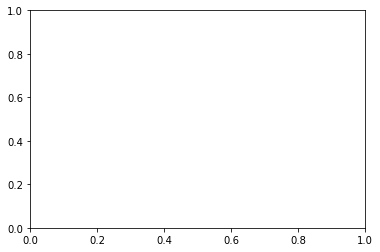

In [11]:
%matplotlib inline

with open(rdn0_file, "rb") as f:
    rdn0_outputs = pickle.load(f)
    
fig,ax=plt.subplots()

print(rdn0_outputs["mcn0"].shape)
for mcn0 in rdn0_outputs["mcn0"]:
    ax.plot(binner.bin_mids, binner(mcn0))
    

In [13]:
ksz_alm = hp.read_alm("/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000/ksz/ksz_rot0.fits")
ksz_masked_alm = hp.read_alm("/pscratch/sd/m/maccrann/cmb/act_dr6/e2e_sims/lmax7000/ksz/ksz_rot0_maskedetc.fits")

In [ ]:
mask_f

In [14]:
cl_0 = curvedsky.alm2cl(ksz_alm)
cl_0_0m = curvedsky.alm2cl(ksz_alm, ksz_masked_alm)
cl_0m_0m = curvedsky.alm2cl(ksz_masked_alm)

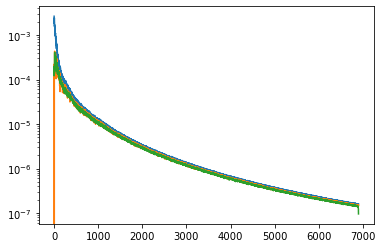

In [19]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(cl_0[100:])
ax.plot(cl_0_0m[100:]/0.25)
ax.plot(cl_0m_0m[100:]/0.25)

ax.set_yscale('log')

# This is very strange - the raw 4-pt (open symbols) are very similar, but the mean-field power for the old sims higher. However, the 
# mean-field subtracted $C_L^{KK}$ is then lower for the newer case (orange)...
# $C_L^{KK} = < K_{AB} - \bar{K}_{AB} >  < K_{CD} - \bar{K}_{CD} > $
#            $= < K_{AB} K_{CD} > + < \bar{K_{AB}} \bar{K_{CD}} > - < \bar{K}_{AB} K_{CD} > - < K_{AB} \bar{K}_{CD} > $

In [ ]:
%matplotlib inline
#plot profile

cl_ksz = np.load("../tests/cl_4e3_2048_50_50_ksz.npy")
with open("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v3_v7000_lmax5000_gausssims/total_Cl_from_data.pkl","rb") as f:
    cltot_dict = pickle.load(f)
    
print(cltot_dict.keys())
fig,ax=plt.subplots(figsize=(5,4))

ells = np.arange(1000,5000)
ax.plot(ells, cl_ksz[1000:5000]/cltot_dict[("hilc","hilc")][1000:5000])
ax.set_yscale('log')
ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$\sqrt{C_l^{\mathrm{ksz}}}/C_l^{\mathrm{tot}}$")

In [ ]:
K_ab_hatX = hp.read_alm("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v3_v7000_lmax5000_gausssims/K_ab_hatX.fits")
K_ab_psh_hatX = hp.read_alm("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc_hilc_hilc_dr6v3_v7000_lmax5000_gausssims_psh/K_ab_psh_hatX.fits")

In [ ]:
print(K_ab_hatX)
print(K_ab_psh_hatX)
cl00 = curvedsky.alm2cl(K_ab_hatX)
cl11 = curvedsky.alm2cl(K_ab_psh_hatX)


In [ ]:
%matplotlib inline
fig,ax=plt.subplots()

ax.plot(cl00)
ax.plot(cl11)
ax.set_yscale('log')

In [ ]:
with open("/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v3_v7000_lmax5000_gausssims_lh/auto_outputs.pkl","rb") as f:
    auto_outputs = pickle.load(f)
    
with open("/pscratch/sd/m/maccrann/ksz_outputs//output_hilc_hilc_hilc_hilc_dr6v3_v7000_lmax5000_gausssims_psh/auto_outputs.pkl","rb") as f:
    auto_outputs_psh = pickle.load(f)
    
print(auto_outputs_psh.keys())

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()


ax.plot( (auto_outputs["N0_lh"]))
ax.plot( (auto_outputs_psh["N0_psh"]))
ax.plot( (auto_outputs_psh["N0_lh"]))

#ax.plot(auto_outputs["N0"][:300])
#ax.plot(auto_outputs_psh["N0_psh"][:300])
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
%matplotlib inline
fig_n0, ax_n0 = plt.subplots(figsize=(5,4))
lfac=2
#plot_clKK(ax, "90_90_90_90", binner, color='C0', label="90 only", lfac=lfac)
raw_auto=False
yscale="log"

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", binner, color='C0',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", binner, color='C1',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_vmask_w217_lmax4000_gaussrdn0", binner, color='C2',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_modelsub_v2_actonly_gaussrdn0", binner, color='C3',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0_mask40", binner, color='C4',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0_mask40", binner, color='C5',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")

plot_rdn0(ax_n0, "/pscratch/sd/m/maccrann/ksz_outputs/test_ilc_ilc_ilc_ilc_nilc", binner, color='C6',
          label=None, lfac=lfac, 
         yscale=yscale, mcn0_linestyle="--")



In [ ]:
%matplotlib inline

fig,ax=plt.subplots(figsize=(5,4))


plot_clKK(ax, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", 
              binner, raw_auto=True, do_err=False)
plot_clKK(ax, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_vmask_w217_lmax4000_oldsims", 
               binner, raw_auto=True, do_err=False)

plot_meanfield(ax, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", 
               "mean_field_nsim64", binner, color=None, label=None)
plot_meanfield(ax, "/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", 
               "mean_field_nsim64", binner, color=None, label=None)



ax.set_yscale('log')
ax.set_ylabel("$C_L^{KK}$")

In [ ]:
#Compare contributions to uncertainty

$C_{l,binned} = \sum_{l in bin} (2l+1) \times C_l / \sum_{l in bin} (2l+1)$

$Var(C_{l,binned}) = [\sum_{l in bin} (2l+1)^2 Var(C_l)] / (\sum_{l in bin} (2l+1))^2$

In [ ]:
%matplotlib inline
fig,ax=plt.subplots()

ax.plot(2/(2*Ls+1)/fsky * theory_N0_wnoise[:binner.lmax+1]**2,
       label="2/(2*Ls+1)/fsky x (theory noisy N0)^2")
ax.plot(2/(2*Ls+1)/fsky * fg_terms["trispectrum_qe"][:binner.lmax+1]**2,
       label="2/(2*Ls+1)/fsky x (fg trispectrum)^2")
ax.plot(2/(2*Ls+1)/fsky * ksz_theory[:binner.lmax+1]**2,
       label="2/(2*Ls+1)/fsky x (ksz signal)^2")
ax.plot(var_CLKK[:200], label="Var$(C_L^{KK})$")
ax.plot(binner.bin_mids, var_CLKK_binned, label="Binned Var$(C_L^{KK})$")
ax.set_yscale('log')
ax.legend()

In [ ]:
%matplotlib inline
fig,ax=plt.subplots()

yscale="symlog"

auto_output_file_old="../bin/output_ilconly_lmin3000_lmax4000/auto_outputs.pkl"
with open(auto_output_file_old,"rb") as f:
    auto_outputs_old=pickle.load(f)
ax.plot(binner.bin_mids, binner.bin_mids**lfac * binner(auto_outputs_old["cl_KK_raw"]),
        color='C0', label="old measurement")

#plot_clKK(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C0', 
##           lfac=lfac, raw_auto=True,
###          tag="dr6lens_lmax4000", label="old ilc",
#         yscale=yscale)
plot_clKK(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C1', 
          lfac=lfac, raw_auto=True,
          tag="dr6lens_ilc-rerun_lmax4000", label="re-run ilc, old maps",
         yscale=yscale)
plot_clKK(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C2', 
           lfac=lfac, raw_auto=True,
          tag="dr6highl_lmax4000", label="new maps",
         yscale=yscale)

#plot Alvarez theory
ax.plot(binner.bin_mids, (binner.bin_mids**lfac)*binner(ksz_theory), color='k', label="kSZ theory")
ax.legend()
ax.set_title("raw auto")
ax.set_xlabel(r"$L$")

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()
lfac=2
plot_rdn0(ax, "hilc_hilc_hilc_hilc", binner, color='C1', label="icii", lfac=lfac)
plot_rdn0(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C2', label="icii lmax=4000", lfac=lfac, tag="lmax4000")

rdn0_output_file_old="../bin/output_lmin3000_lmax4000/rdn0_outputs.pkl"
with open(rdn0_output_file_old,"rb") as f:
    rdn0_old=pickle.load(f)
rdn0_scatter_old = get_rdn0_scatter(rdn0_old["rdn0"], binner)
mcn0_scatter_old = get_rdn0_scatter(rdn0_old["mcn0"], binner)
ax.plot(binner.bin_mids, binner.bin_mids**lfac*rdn0_scatter_old, color='C3', label='icii lmax=4000, old maps')
ax.plot(binner.bin_mids, binner.bin_mids**lfac*mcn0_scatter_old, '--', color='C3', label='icii lmax=4000, old maps')


ax.legend()
ax.set_title("rdn0 (mcn0) scatter")
ax.set_yscale('log')


In [ ]:
%matplotlib inline

fig,ax=plt.subplots()
lfac=2
plot_rdn0(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C1', 
          label="icii", lfac=lfac, scatter=False)
plot_rdn0(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C2', 
          label="icii lmax=4000", lfac=lfac, tag="lmax4000",
         scatter=False)

rdn0_output_file_old="../bin/output_lmin3000_lmax4000/rdn0_outputs.pkl"
with open(rdn0_output_file_old,"rb") as f:
    rdn0_old=pickle.load(f)

ax.plot(binner.bin_mids, binner.bin_mids**lfac*binner(rdn0_old["rdn0"].mean(axis=0)), color='C3', label='icii lmax=4000, old maps')
ax.plot(binner.bin_mids, binner.bin_mids**lfac*binner(rdn0_old["mcn0"].mean(axis=0)), '--', color='C3', label='icii lmax=4000, old maps')


ax.legend()
ax.set_title("rdn0 (mcn0) mean")
ax.set_yscale('log')

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()
lfac=2
plot_rdn0(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C1', label="icii", lfac=lfac)
plot_rdn0(ax, "hilc_hilc-tszandcibd_hilc_hilc", binner, color='C2', label="icii lmax=4000", lfac=lfac, tag="lmax4000")

rdn0_output_file_old="../bin/output_lmin3000_lmax4000/rdn0_outputs.pkl"
with open(rdn0_output_file_old,"rb") as f:
    rdn0_old=pickle.load(f)
rdn0_scatter_old = get_rdn0_scatter(rdn0_old["rdn0"], binner)
mcn0_scatter_old = get_rdn0_scatter(rdn0_old["mcn0"], binner)
ax.plot(binner.bin_mids, binner.bin_mids**lfac*rdn0_scatter_old, color='C3', label='icii lmax=4000, old maps')
ax.plot(binner.bin_mids, binner.bin_mids**lfac*mcn0_scatter_old, '--', color='C3', label='icii lmax=4000, old maps')


ax.legend()
ax.set_yscale('log')

In [ ]:
#### read rdn0 output

In [ ]:
#errorbars seem very off. compare to previous maps (with proper sims)
rdn0_output_file_old="../bin/output_ilconly_lmin3000_lmax4000/rdn0_outputs.pkl"
with open(rdn0_output_file_old,"rb") as f:
    rdn0_old=pickle.load(f)
    
auto_output_file_old="../bin/output_ilconly_lmin3000_lmax4000/auto_outputs.pkl"
with open(auto_output_file_old,"rb") as f:
    auto_outputs_old=pickle.load(f)
    
rdn0_output_file_new_nomask="../scripts/test_hilc_hilc_hilc_hilc_lmax4000/rdn0_outputs.pkl"
with open(rdn0_output_file_new_nomask, "rb") as f:
    rdn0_new_nomask = pickle.load(f)
rdn0_output_file_new_mask="../scripts/test_hilc_hilc_hilc_hilc_lmax4000_masksims/rdn0_outputs.pkl"
with open(rdn0_output_file_new_mask, "rb") as f:
    rdn0_new_mask = pickle.load(f)
    

    
auto_outputs_new_file="../scripts/test_hilc_hilc_hilc_hilc_lmax4000/auto_outputs.pkl"
with open(auto_outputs_new_file, "rb") as f:
    auto_outputs_new = pickle.load(f)
print(auto_outputs_new.keys())

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()
ax.plot(binner.bin_mids, binner(auto_outputs_old["cl_KK_raw"]), label="old raw auto")
ax.plot(binner.bin_mids, binner(auto_outputs_new["cl_KK_raw"]), label="new raw auto")
ax.plot(binner.bin_mids, binner(auto_outputs_old["N0"]))
ax.plot(binner.bin_mids, binner(auto_outputs_new["N0"]))
ax.set_yscale('log')

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(binner.bin_mids, binner(rdn0_old["rdn0"].mean(axis=0)), label="old")
ax.plot(binner.bin_mids, binner(rdn0_new_nomask["rdn0"].mean(axis=0)), label="new")
ax.plot(binner.bin_mids, binner(rdn0_new_mask["rdn0"].mean(axis=0)),
       label="new masked")

#ax.plot(auto_outputs_new["N0"][:200], label="theory N0")
#ax.plot(auto_outputs_new["N0_nonoise"][:200], label="theory N0 no noise")
ax.set_yscale("log")
ax.legend()

In [ ]:
n0_output_file = "../scripts/test_%s/rdn0_outputs.pkl"%est_maps
with open(n0_output_file, "rb") as f:
    rdn0_outputs = pickle.load(f)
print(rdn0_outputs.keys())

In [ ]:
print(rdn0_outputs['mcn0'].shape)

In [ ]:
#also add theory
outputs_dir='/pscratch/sd/m/maccrann/cmb/fg_outputs'
def get_fg_terms(tag, recon_tag, freq):
    fg_term_file = opj(outputs_dir, tag, 
                       "ksz2_fg_terms_%s/fg_terms_%s.npy"%(
                           recon_tag, freq)
                      )
    return np.load(fg_term_file)
fg_terms = get_fg_terms("allfgs_nemo-wdr6dn_tsz-nemo-model-snr5-mask-snr4-mr6-lowz0.1-mr30_ps-model-snr4_wplanck-ps2",
                        "lmax6000", "ilc_deproj-tsz-cib_ilc_ilc")
ksz_theory = fg_terms["cl_K_ksz"]

In [ ]:
print(auto_outputs.keys())

def get_rdn0_scatter(rdn0_array, binner):
    binned_rdn0_array = np.zeros((rdn0_array.shape[0], binner.nbin))
    for i,a in enumerate(rdn0_array):
        binned_rdn0_array[i] = binner(a)
    return np.std(binned_rdn0_array, axis=0)

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

cl_KK = auto_outputs["cl_KK_raw"]-rdn0_outputs["rdn0"].mean(axis=0)

cl_KK_err = 2*get_rdn0_scatter(rdn0_outputs["rdn0"],binner)**2 / (2*binner.bin_mids+1) / 0.27
print(rdn0_outputs["rdn0"])
ax.errorbar(binner.bin_mids, binner(cl_KK), yerr=cl_KK_err, color='C0', label="C_L^KK")
ax.plot(binner.bin_mids, binner(rdn0_outputs["rdn0"].mean(axis=0)), color='C1', label="RDNO")
ax.plot(binner.bin_mids, binner(rdn0_outputs["mcn0"].mean(axis=0)), color='C2', label="MCN0")
#ax.plot(binner.bin_mids, -binner(cl_KK), '--', color='C0', label="C_L^KK")
#ax.plot(binner.bin_mids, binner(rdn0_outputs["rdn0"].mean(axis=0)), label="Gaussian sim rdn0")
ax.plot(binner.bin_mids, -binner(rdn0_outputs["rdn0"].mean(axis=0)), '--', color='C1')
#ax.plot(binner.bin_mids, binner(rdn0_outputs["mcn0"].mean(axis=0)), label="Gaussian sim mcn0")
#ax.plot(binner.bin_mids, -binner(rdn0_outputs["mcn0"].mean(axis=0)), '--', color='C2')
ax.plot(binner.bin_mids, binner(auto_outputs["N0"]), color='C3',label="theory N0")
ax.plot(binner.bin_mids, binner(auto_outputs["N0_nonoise"]), color='C4', label="theory N0 no noise")
ax.plot(binner.bin_mids, binner(ksz_theory), color='C5', label="kSZ theory")
ax.set_yscale('log')
ax.legend()


### compare full sim rdn0 to gaussian sim version

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

with open("../scripts/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_cldata_smooth-301-2_modelsub_v2_re-run_w217_lmax4000_fullsimrdn0/auto_outputs.pkl", "rb") as f:
    auto_outputs = pickle.load(f)
with open("../scripts/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_cldata_smooth-301-2_modelsub_v2_re-run_w217_lmax4000_fullsimrdn0/rdn0_outputs.pkl", "rb") as f:
    n0_fullsim = pickle.load(f)
with open("../scripts/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_cldata_smooth-301-2_modelsub_v2_re-run_w217_lmax4000_gausssimrdn0/rdn0_outputs.pkl", "rb") as f:
    n0_gausssim = pickle.load(f)

ax.plot(binner.bin_mids, binner(n0_fullsim["mcn0"].mean(axis=0)), color="C0", label="Full sim MCN0")
ax.plot(binner.bin_mids, binner(n0_fullsim["rdn0"].mean(axis=0)), color="C1", label="Full sim RDN0")
ax.plot(binner.bin_mids, -binner(n0_fullsim["rdn0"].mean(axis=0)), ':', color="C1")
ax.plot(binner.bin_mids, binner(n0_gausssim["mcn0"].mean(axis=0)), color="C2", label="Gaussian sims MCN0")
ax.plot(binner.bin_mids, binner(n0_gausssim["rdn0"].mean(axis=0)), color="C3", label="Gaussian sims RDN0")
ax.plot(binner.bin_mids, -binner(n0_gausssim["rdn0"].mean(axis=0)), ':', color="C3", label="Gaussian sims RDN0")
ax.plot(binner.bin_mids, binner(auto_outputs["N0"]), label="theory N0", color="C4")
ax.plot(binner.bin_mids, binner(auto_outputs["N0_nonoise"]),label="theory N0 noiseless", color="C5")
ax.set_yscale('log')
ax.legend()


In [ ]:
d="/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0/mean_field_nsim16"
d_wfg="/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0/mean_field_nsim16_wfg"

with open(opj(d, "Ks_ab_mean.pkl"), "rb") as f:
    Ks_ab_mean = pickle.load(f)
with open(opj(d, "Ks_cd_mean.pkl"), "rb") as f:
    Ks_cd_mean = pickle.load(f)  
with open(opj(d_wfg, "Ks_ab_mean.pkl"), "rb") as f:
    Ks_ab_mean_wfg = pickle.load(f)
with open(opj(d_wfg, "Ks_cd_mean.pkl"), "rb") as f:
    Ks_cd_mean_wfg = pickle.load(f)

In [ ]:
mf0 = split_phi_to_cl(np.array(Ks_ab_mean), np.array(Ks_cd_mean))
mf_wfg = split_phi_to_cl(np.array(Ks_ab_mean_wfg), np.array(Ks_cd_mean_wfg))

In [ ]:
%matplotlib inline

binner_highL = ClBinner(lmin=10., lmax=1000., nbin=50)
fig,ax=plt.subplots()
#ax.plot(binner.bin_mids, binner(mf0))
#ax.plot(binner.bin_mids, binner(mf_wfg))
ax.plot(binner_highL(mf0))
ax.plot(binner_highL(mf_wfg))
ax.set_yscale('log')

In [ ]:
outdir="/pscratch/sd/m/maccrann/ksz_outputs"
with open(opj(outdir, "test_hilc_hilc_hilc_hilc_dr6lens_ilc-rerun_lmax4000_fullsimrdn0", "total_Cl_from_data.pkl"), "rb") as f:
    cltot_data_old = pickle.load(f)
    
with open(opj(outdir, "test_hilc_hilc_hilc_hilc_dr6lens_vmask_w217_lmax4000_oldsims", "total_Cl_from_data.pkl"), "rb") as f:
    cltot_data_new = pickle.load(f)

In [ ]:
fig,ax=plt.subplots()

ax.plot(cltot_data_old["hilc","hilc"][3000:])
ax.plot(cltot_data_new["hilc","hilc"][3000:])


ax.set_yscale('log')

In [ ]:
alm_file_old_90 = "/pscratch/sd/m/maccrann/cmb/act_dr6/kcoadd_f090_sub_cal_split0modelsub.fits"
alm_file_new_90 = "/pscratch/sd/m/maccrann/cmb/act_dr6/coadd_data/kcoadd_f_90_lmax7000_split0.fits"
cl_old_90 = curvedsky.alm2cl(hp.read_alm(alm_file_old_90))
cl_new_90 = curvedsky.alm2cl(hp.read_alm(alm_file_new_90))

alm_file_old_150 = "/pscratch/sd/m/maccrann/cmb/act_dr6/kcoadd_f150_sub_cal_split0modelsub.fits"
alm_file_new_150 = "/pscratch/sd/m/maccrann/cmb/act_dr6/coadd_data/kcoadd_f_150_lmax7000_split0.fits"
cl_old_150 = curvedsky.alm2cl(hp.read_alm(alm_file_old_150))
cl_new_150 = curvedsky.alm2cl(hp.read_alm(alm_file_new_150))

In [ ]:
mask_old = enmap.read_map("/global/cfs/projectdirs/act/data/synced_maps/DR6_lensing/masks/act_mask_20220316_GAL060_rms_70.00_d2sk.fits")
mask_new = enmap.read_map("/global/cfs/projectdirs/act/data/maccrann/dr6/act_mask_20220316_GAL060_rms_70.00_downgrade_None.fits")


w2_old = maps.wfactor(2, mask_old)
w2_new = maps.wfactor(2, mask_new)
w4_old = maps.wfactor(4, mask_old)
w4_new = maps.wfactor(4, mask_new)
print("w2_old:", w2_old)
print("w2_new:", w2_new)
print(w4_old)
print(w4_new)
print(maps.wfactor(1, mask_old))
print(maps.wfactor(1, mask_new))

In [ ]:
mask_d2 = mask_new.downgrade(2)
mask_d2.write("/global/cfs/projectdirs/act/data/maccrann/dr6/act_mask_20220316_GAL060_rms_70.00_d2.fits")

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

binner=ClBinner(lmin=10, lmax=4000, nbin=50)

lmax=4000
ells=np.arange(lmax+1)

ax.plot(binner.bin_mids, w2_old/w2_new * binner(cl_new_90)/binner(cl_old_90))
ax.plot(binner.bin_mids, w2_old/w2_new * binner(cl_new_150)/binner(cl_old_150))
ax.set_ylabel("Cl^TT new /Cl^TT old")
ax.set_xlabel(r"$l$")


In [ ]:
import healpy as hp

m = hp.read_map("/global/cfs/projectdirs/act/data/agora_sims/outputs/act/agora_act_150ghz_lcibNG_ltszNGbahamas80_lkszNGbahamas80_lradNG_uk.fits")

In [14]:
#read in cltot_dict
with open("/pscratch/sd/m/maccrann/ksz_outputs/output_hilc_hilc-tszandcibd_hilc_hilc_dr6v3_v7000_lmax4000_mask60sk_fullsims/total_Cl_from_data.pkl","rb") as f:
    cltot_dict = pickle.load(f)

In [15]:
print(cltot_dict.keys())

dict_keys([('hilc', 'hilc'), ('hilc', 'hilc-tszandcibd'), ('hilc-tszandcibd', 'hilc'), ('hilc-tszandcibd', 'hilc-tszandcibd')])


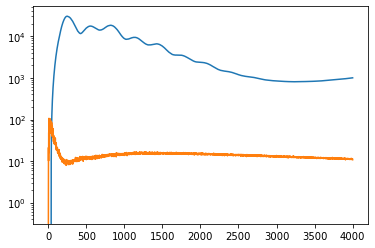

In [21]:
%matplotlib inline
fig,ax=plt.subplots()
ell=np.arange(len(cltot_dict[("hilc","hilc")]))
ax.plot(ell, ell**2 * cltot_dict[("hilc","hilc")])
ax.set_yscale('log')
cl_rksz=np.load("../tests/cl_4e3_2048_50_50_ksz.npy")
ax.plot(ell, ell**2*cl_rksz[:len(ell)])

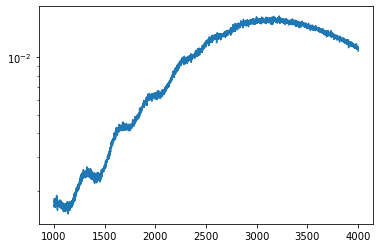

In [24]:
%matplotlib inline

fig,ax=plt.subplots()
ax.plot(ell[1000:], (cl_rksz[:len(ell)]/cltot_dict[("hilc","hilc")])[1000:])
ax.set_yscale('log')


In [48]:
(16 + 21.90 + 22.50 + 12.90 + 30.40 + 17.70 + 13.00 + 30 + 24 + 6 + 19.50 + 17.20+10.20)/2

120.64999999999998

In [6]:
d=np.load("/pscratch/sd/m/maccrann/cmb/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl/prep_map/cmb_orig/Cltot_data.npy")
print(d.dtype.names)

('Nltt_0093', 'Nlee_0093', 'Nlbb_0093', 'Clfg_0093', 'Cltt_total_0093', 'Nltt_0145', 'Nlee_0145', 'Nlbb_0145', 'Clfg_0145', 'Cltt_total_0145', 'Nltt_0217', 'Nlee_0217', 'Nlbb_0217', 'Clfg_0217', 'Cltt_total_0217', 'Nltt_0353', 'Nlee_0353', 'Nlbb_0353', 'Clfg_0353', 'Cltt_total_0353', 'Nltt_0545', 'Nlee_0545', 'Nlbb_0545', 'Clfg_0545', 'Cltt_total_0545', 'Nltt_freqcoadd', 'Nlee_freqcoadd', 'Nlbb_freqcoadd', 'Clfg_freqcoadd', 'Cltt_total_freqcoadd', 'Clee_total_freqcoadd', 'Clbb_total_freqcoadd', 'Cltt_total_0093-0093', 'Cltt_total_0093-0145', 'Cltt_total_0093-0217', 'Cltt_total_0093-0353', 'Cltt_total_0093-0545', 'Cltt_total_0145-0145', 'Cltt_total_0145-0217', 'Cltt_total_0145-0353', 'Cltt_total_0145-0545', 'Cltt_total_0217-0217', 'Cltt_total_0217-0353', 'Cltt_total_0217-0545', 'Cltt_total_0353-0353', 'Cltt_total_0353-0545', 'Cltt_total_0545-0545', 'w_T_ilc_0', 'w_T_ilc_1', 'w_T_ilc_2', 'w_T_ilc_3', 'w_T_ilc_4', 'w_T_deproj-tsz_0', 'w_T_deproj-tsz_1', 'w_T_deproj-tsz_2', 'w_T_deproj-tsz

In [7]:
alm_ilc = hp.read_alm("/pscratch/sd/m/maccrann/cmb/fg_outputs/allfgs_nemo-wdr6dn_tsz-nemo-model-snr5_ps-model-snr4_wplanck-ps2_mask60sk_dataCl/prep_map/cmb_orig/fg_nonoise_alms_ilc.fits")
cl_from_alm = curvedsky.alm2cl(alm_ilc)/w2

In [8]:
cl_from_d = d["Clfg_ilc"]

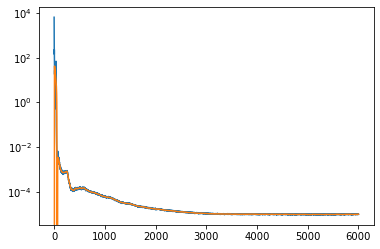

In [10]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(cl_from_alm)
ax.plot(cl_from_d)
ax.set_yscale('log')